# Imports

In [46]:
import yfinance        as yf
import seaborn         as sns
import numpy           as np
import pandas          as pd
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve, mean_squared_error

from matplotlib              import pyplot as plt
from pandas_datareader       import data   as pdr
from IPython.core.display    import HTML

## Helper Functions

In [47]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading data

In [48]:
yf.pdr_override()

In [49]:
start = '2017-01-01'
#end = '2019-12-31'
end = '2019-12-31'

data = pdr.get_data_yahoo( '^GSPC', start=start, end=end )

[*********************100%***********************]  1 of 1 completed


In [50]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000


In [51]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,3226.050049,3227.780029,3222.300049,3224.010010,3224.010010,3064530000
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296530000
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2164540000
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2429150000
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3021720000


# Data Description

In [52]:
df2 = data.copy()

In [53]:
df2.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Times Series Visualization

In [54]:
df3 = df2.copy()

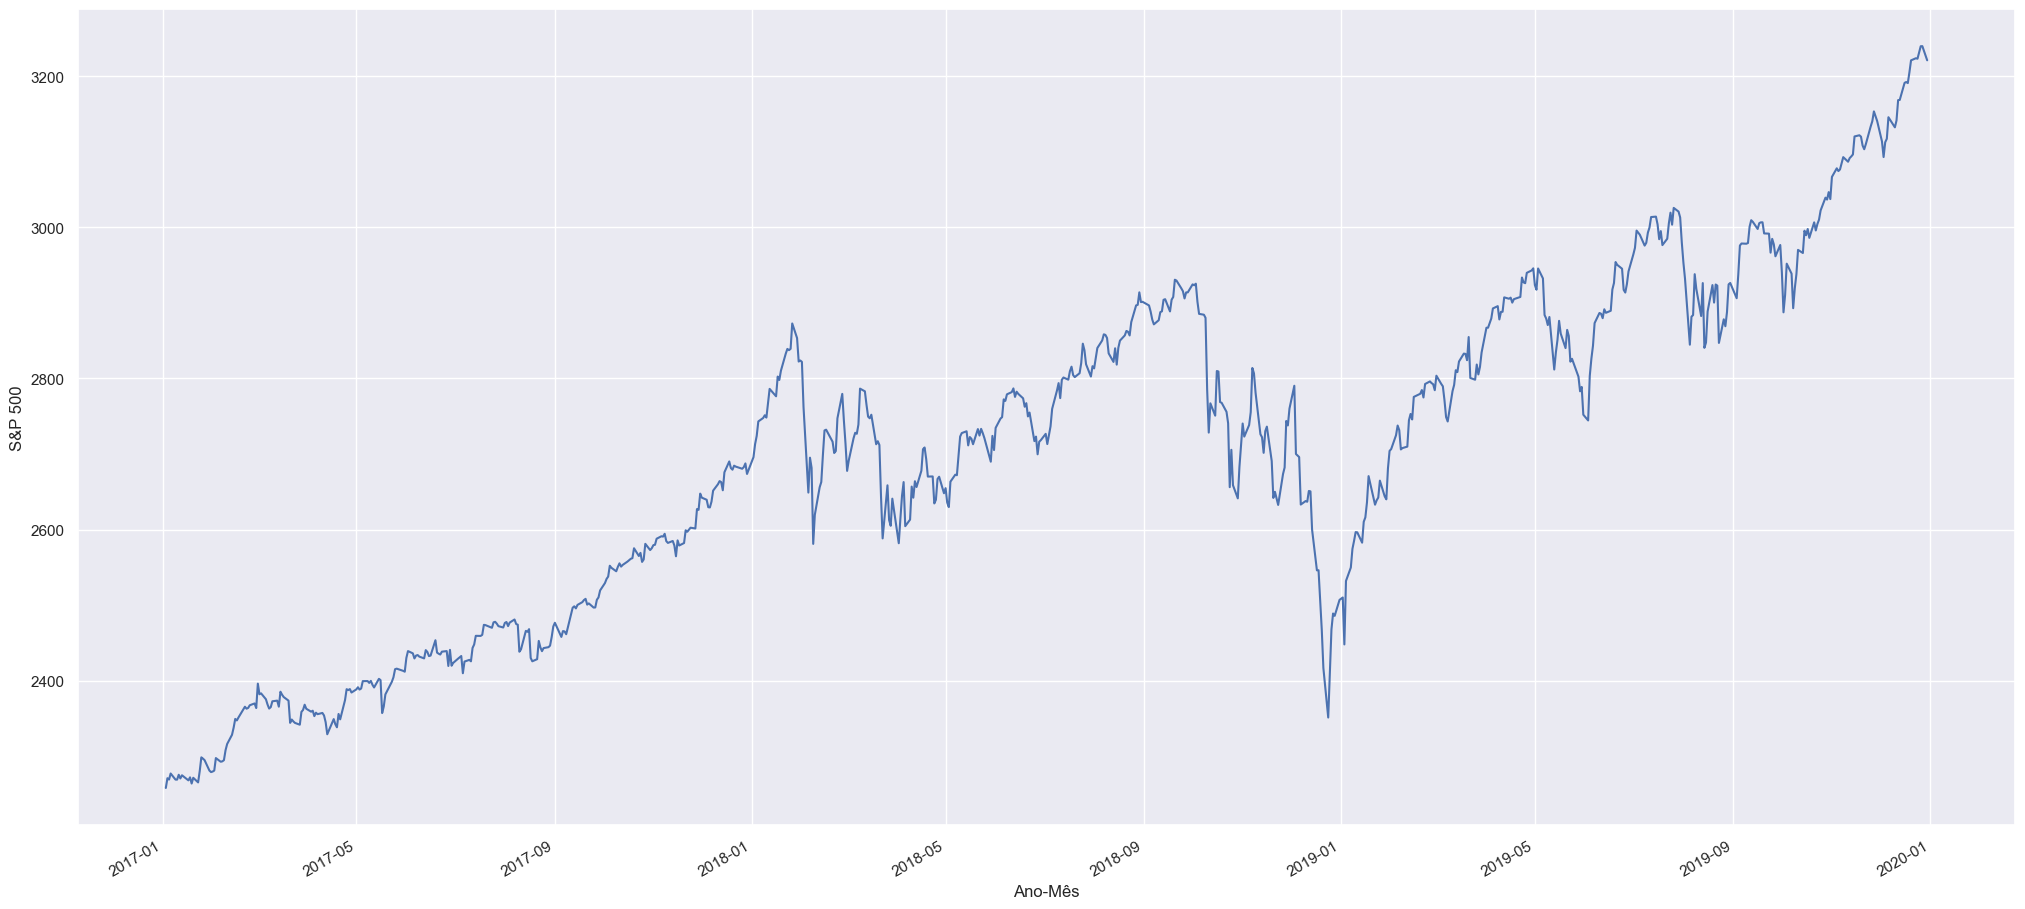

In [57]:
df3['Close'].plot()
#plt.title( 'Gráfico da Série S&P 500' );
plt.ylabel('S&P 500')
plt.xlabel('Ano-Mês');

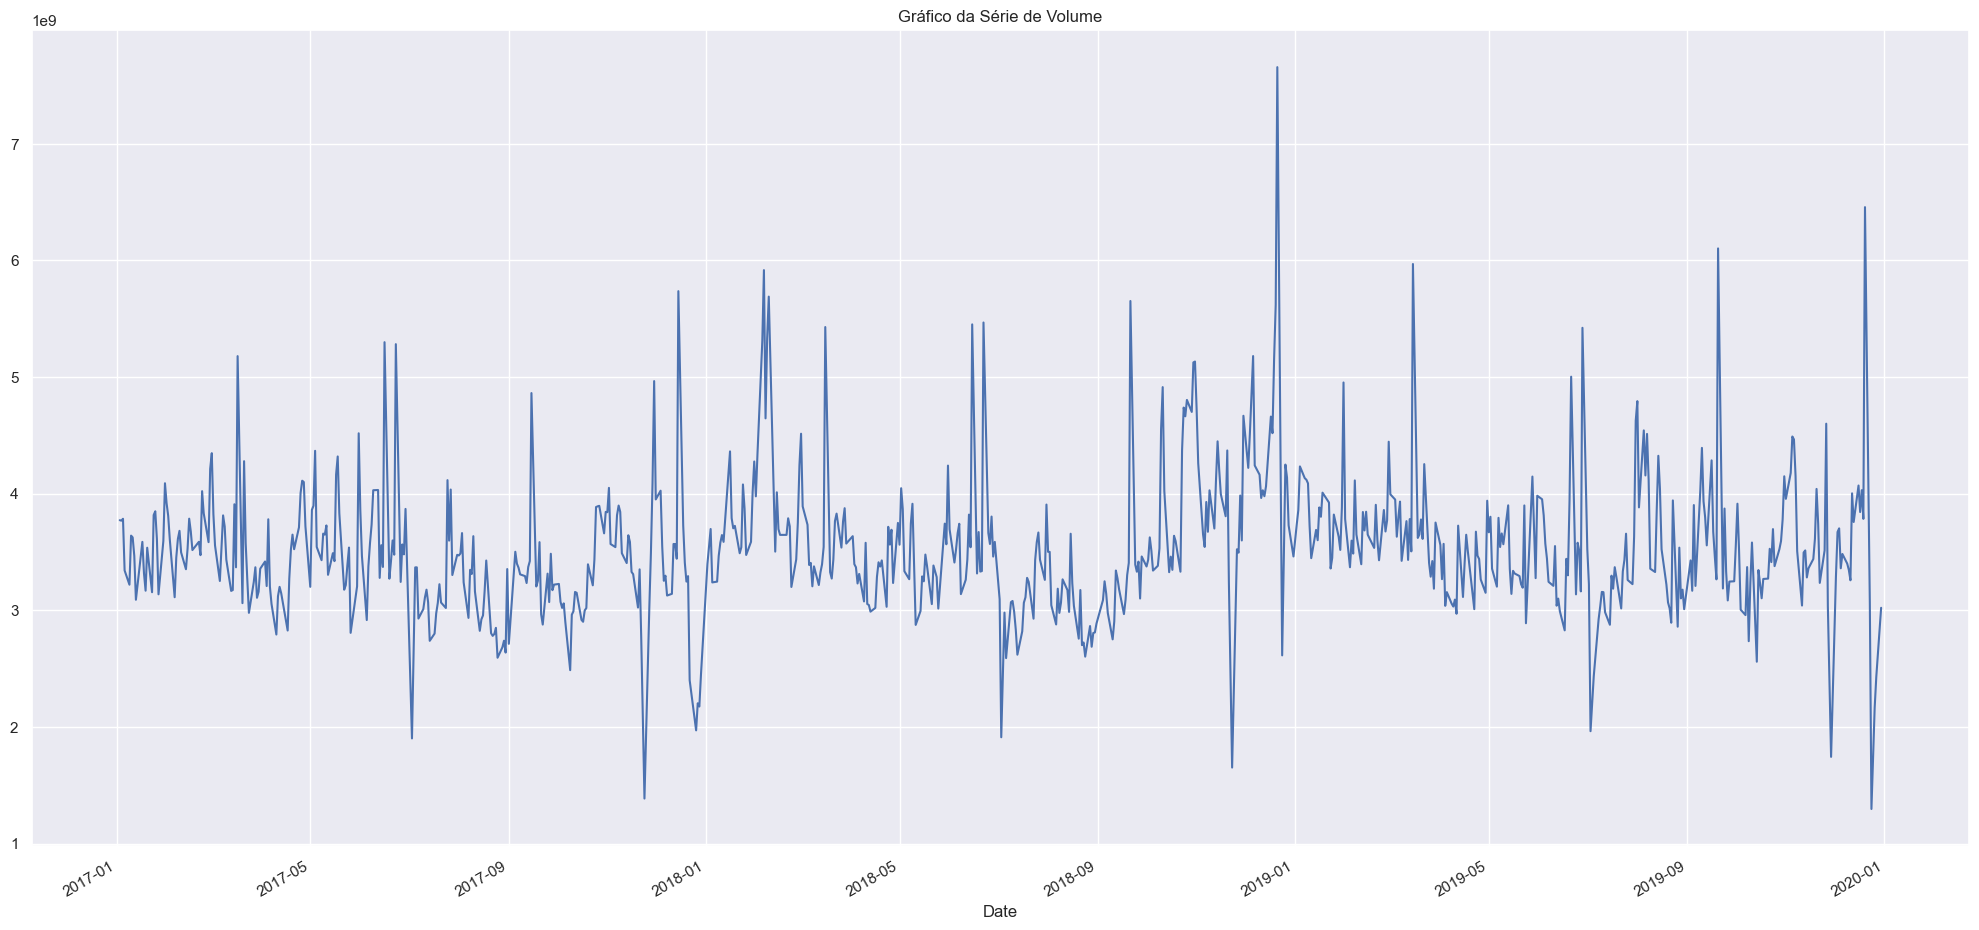

In [58]:
df3['Volume'].plot();
plt.title( 'Gráfico da Série de Volume' );

# Exploratory Data Analysis

In [59]:
df4 = df3.copy()

In [60]:
df4[['High','Low','Open','Close']].describe()

,High,Low,Open,Close
count,753.000000,753.000000,753.000000,753.000000
mean,2713.128286,2690.109801,2702.201619,2702.460769
std,227.978260,226.121282,227.091167,226.960049
min,2263.879883,2245.129883,2251.570068,2257.830078
25%,2508.320068,2492.139893,2498.939941,2502.219971
50%,2737.830078,2709.179932,2722.610107,2723.070068
75%,2890.030029,2862.080078,2876.090088,2878.379883
max,3247.929932,3234.370117,3247.229980,3240.020020


In [61]:
# lag de X periodos

periodos = 1

# lag positivo de X periodos
df4['Lag_P1'] = df4['Close'].shift( periodos )

In [62]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1
Date,,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000,NaN
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000,2257.830078
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000,2270.750000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000,2269.000000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000,2276.979980


In [63]:
# Dummy para saber se o dia atual é Alta(1) ou Baixa(0)

df4['High_Low'] = np.where( df4['Close'] > df4['Lag_P1'], 1, 0 )

In [64]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low
Date,,,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000,NaN,0
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000,2257.830078,1
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000,2270.750000,0
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000,2269.000000,1
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000,2276.979980,0


In [65]:
df4['High_Low'].mean()

0.5617529880478087

In [66]:
# Calculando o Retorno

df4['Retorno'] = df4['Close'].pct_change( periodos )

In [67]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000,NaN,0,NaN
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000,2257.830078,1,0.005722
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000,2270.750000,0,-0.000771
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000,2269.000000,1,0.003517
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000,2276.979980,0,-0.003549


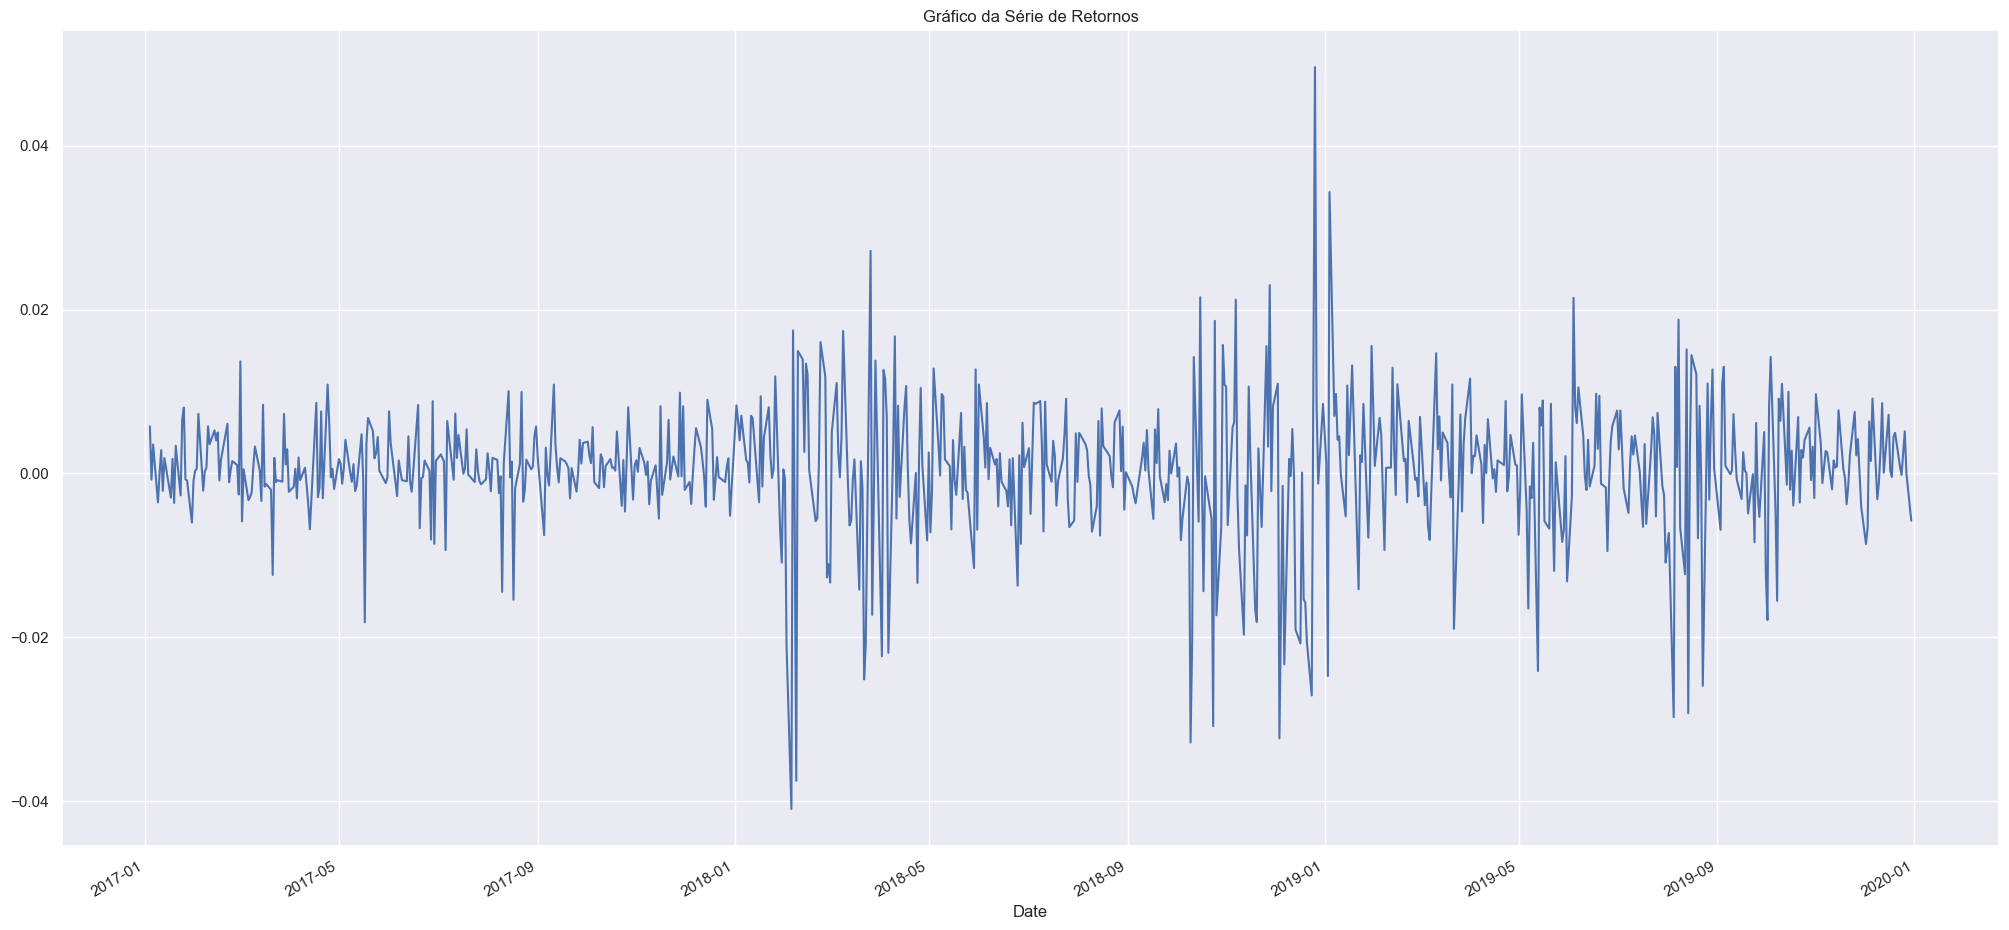

In [68]:
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

C:\Users\lucas\AppData\Local\Temp\ipykernel_440\3695061061.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


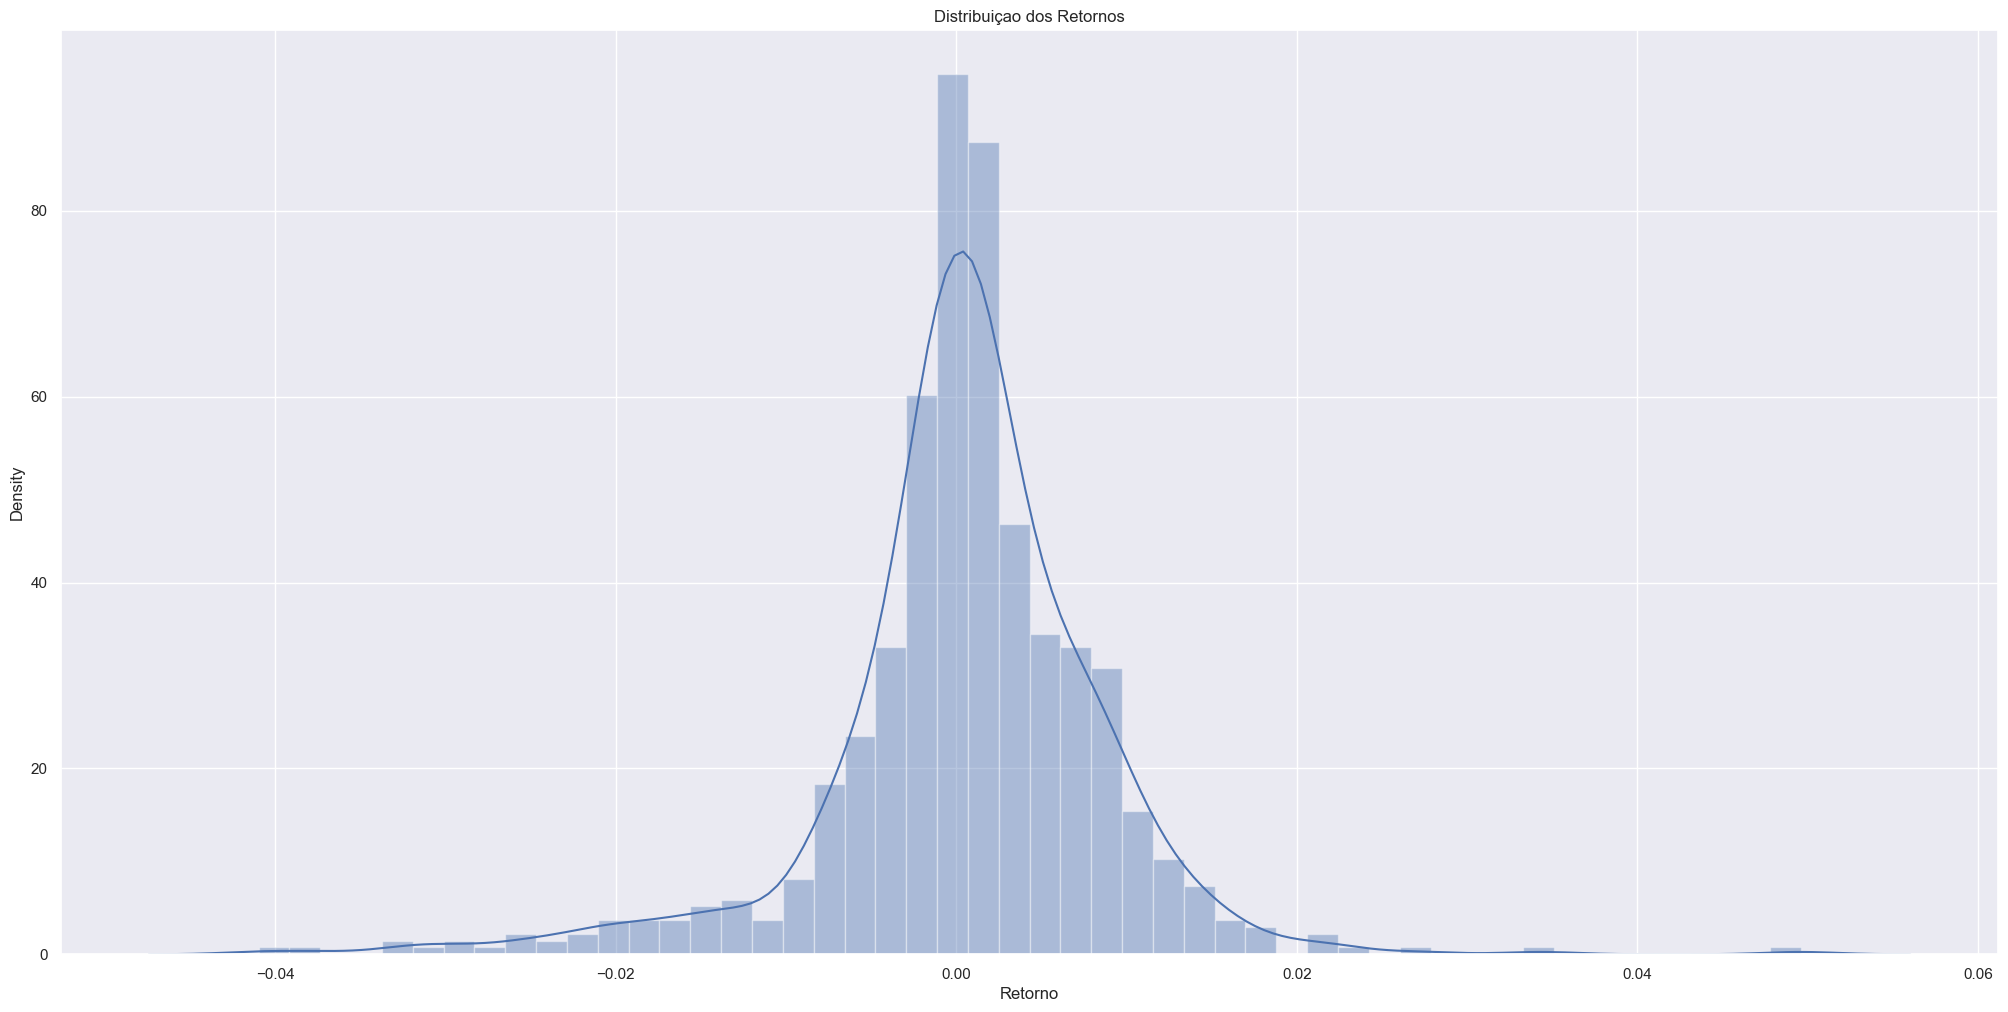

In [69]:
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

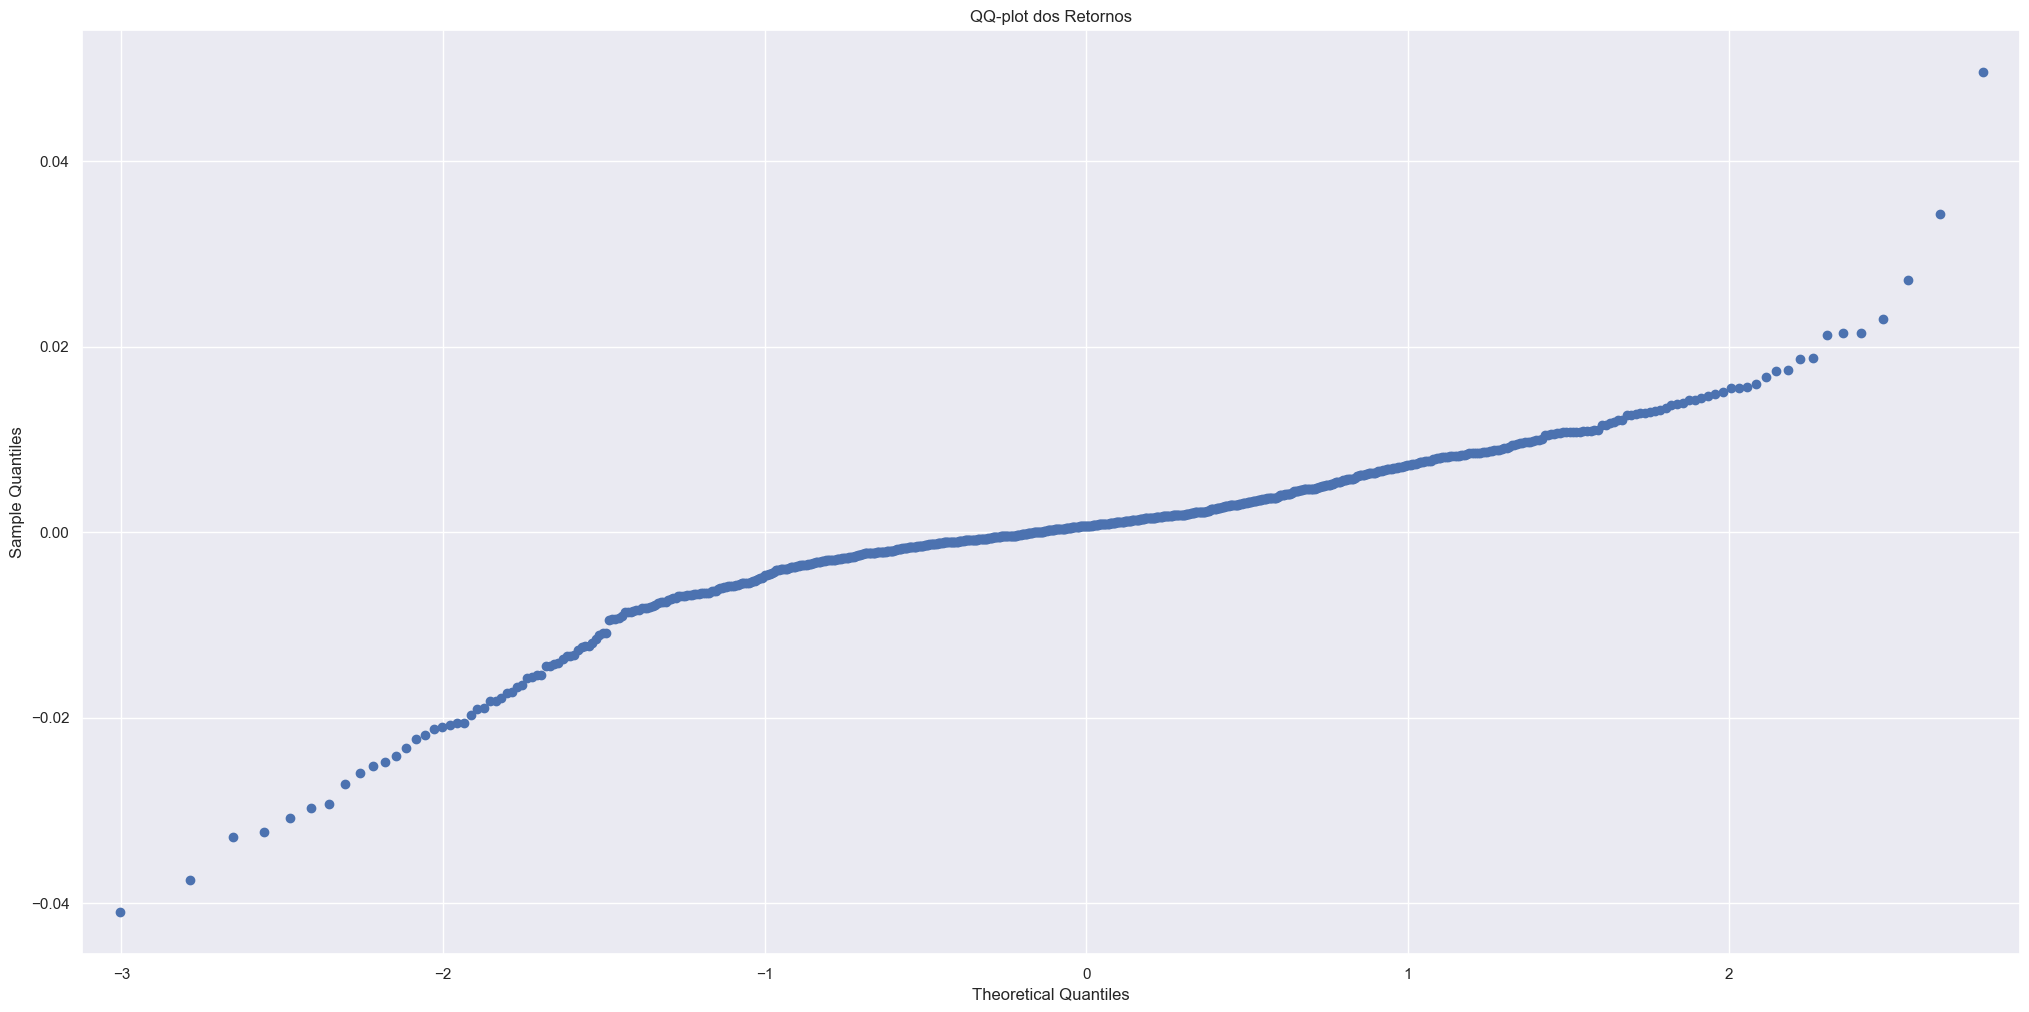

In [70]:
sm.qqplot( df4['Retorno'] )
plt.title( 'QQ-plot dos Retornos' );

Consolidando os gráficos da série histórica, série de retornos, distribuição dos retornos e qq-plot em uma mesma imagem.

C:\Users\lucas\AppData\Local\Temp\ipykernel_440\1516391380.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


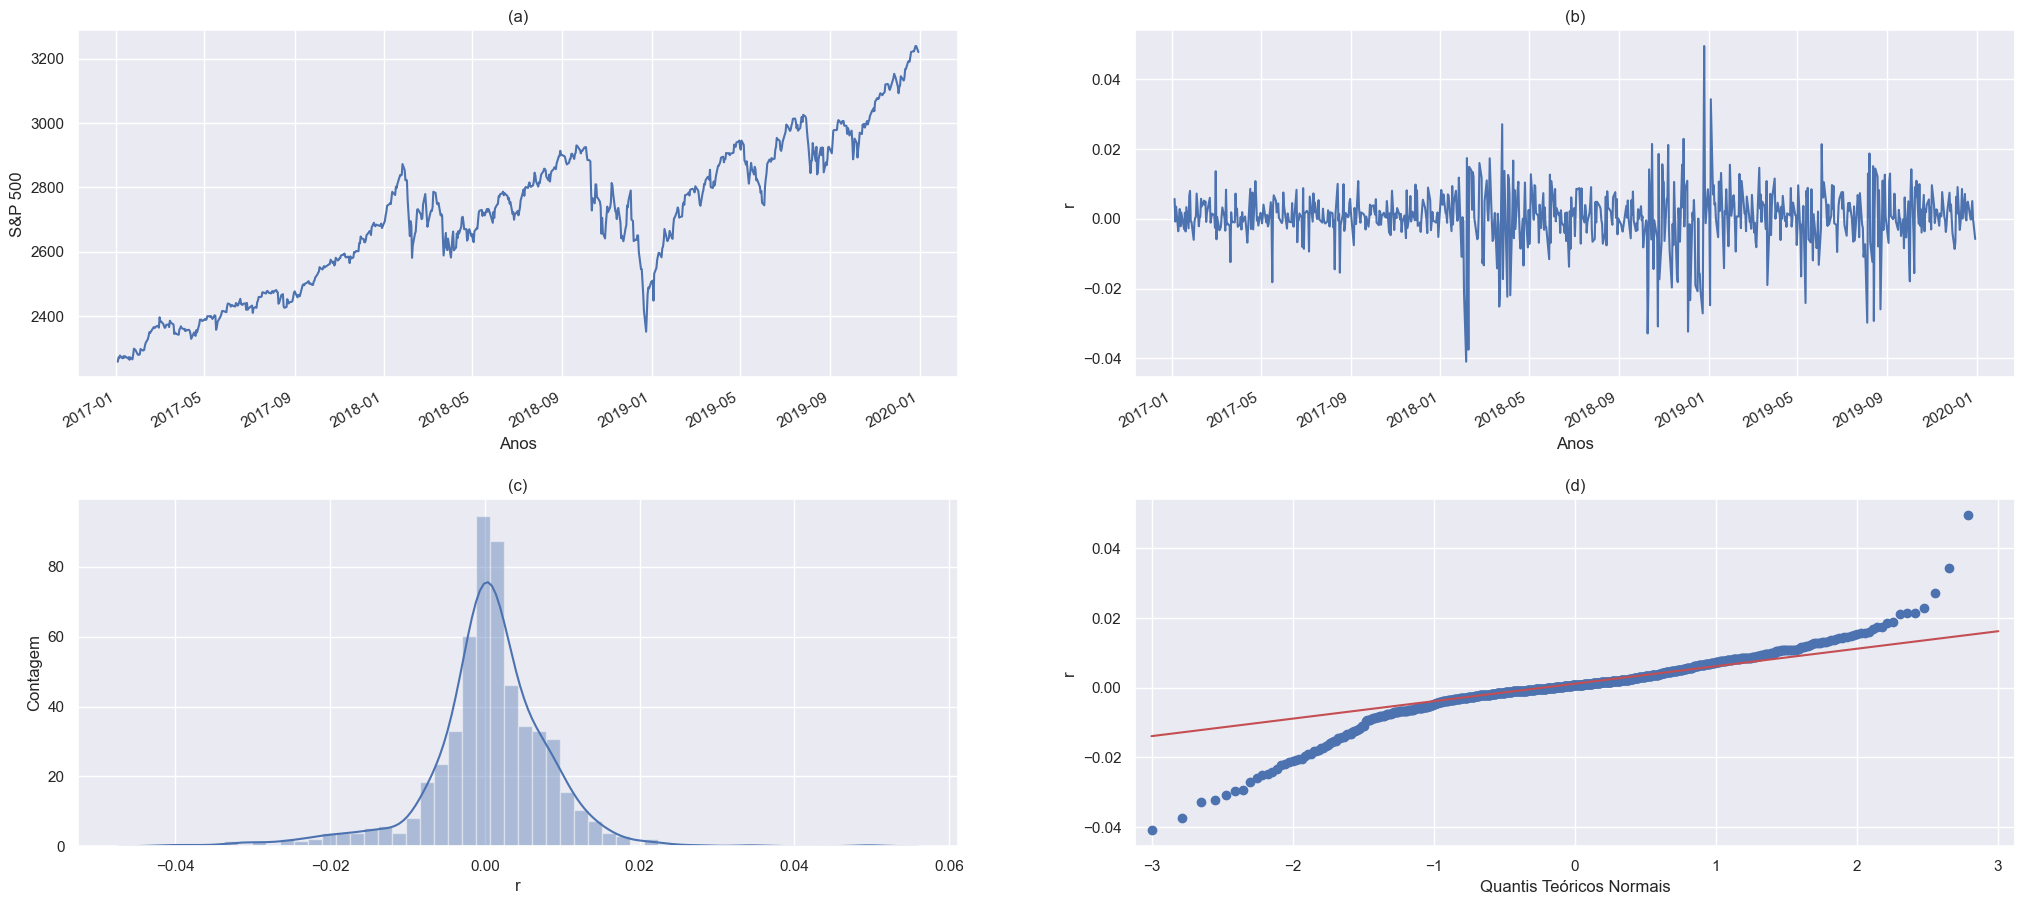

In [71]:
plt.subplot( 2, 2, 1 )
plt.subplots_adjust(hspace=0.35)
df3['Close'].plot()
plt.title('(a)')
plt.ylabel('S&P 500')
plt.xlabel('Anos');

plt.subplot( 2, 2, 2 )
df4['Retorno'].plot()
plt.title('(b)')
plt.ylabel('r')
plt.xlabel('Anos');

plt.subplot( 2, 2, 3 )
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title('(c)')
plt.ylabel('Contagem')
plt.xlabel('r');

#plt.subplot( 2, 2, 4 )
sm.qqplot( df4['Retorno'], line ='q', ax=plt.subplot( 2, 2, 4 ) ) 
plt.title('(d)')
plt.ylabel('r')
plt.xlabel('Quantis Teóricos Normais');

In [72]:
df4['Retorno'].describe()

count    752.000000
mean       0.000505
std        0.008070
min       -0.040979
25%       -0.002243
50%        0.000691
75%        0.004513
max        0.049594
Name: Retorno, dtype: float64

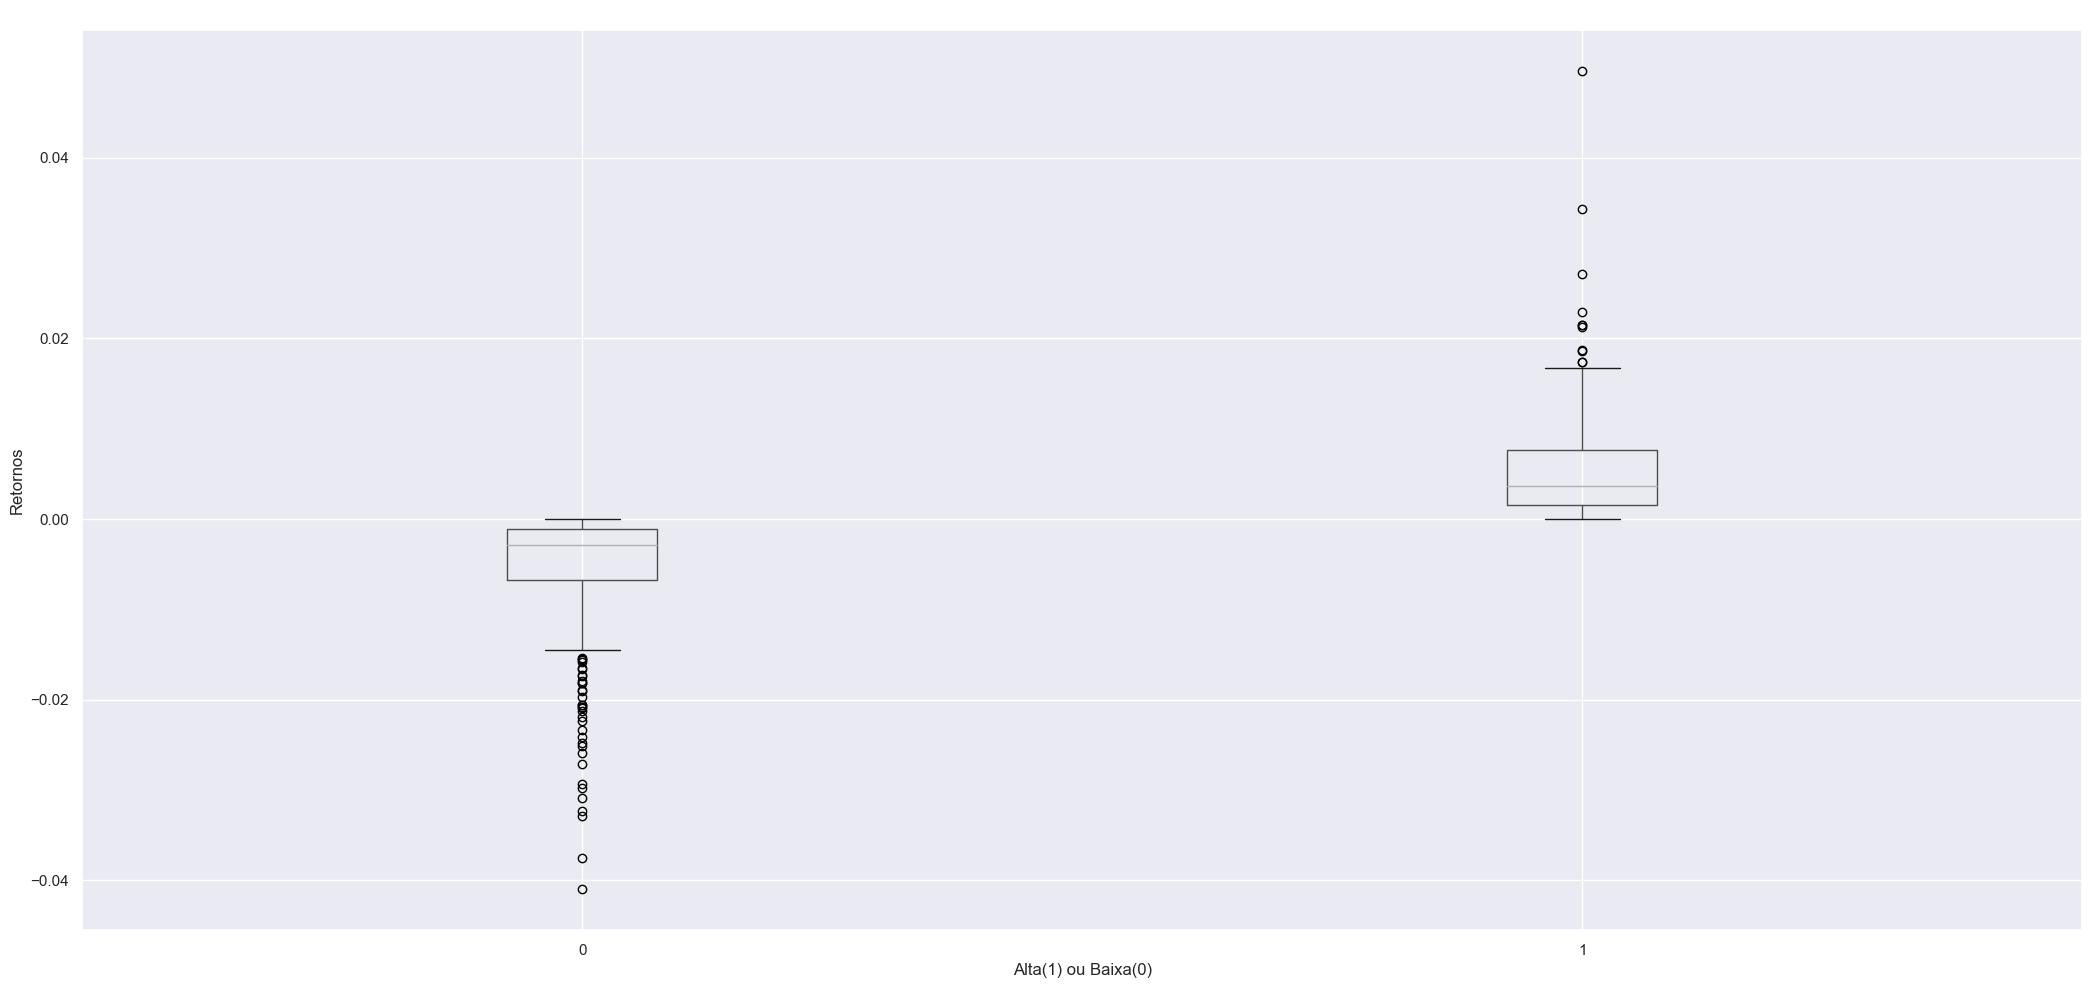

In [73]:
df4.boxplot( by='High_Low', column=['Retorno'], grid = True ) 
title = ' '
plt.title( title )
plt.suptitle( '' ) # para eliminar o titulo padrao do boxplot do pandas
plt.ylabel( 'Retornos' )
plt.xlabel( 'Alta(1) ou Baixa(0)' )
plt.show();

# Feature Engineering

In [74]:
df5 = df4.copy()

In [75]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000,NaN,0,NaN
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000,2257.830078,1,0.005722
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000,2270.750000,0,-0.000771
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000,2269.000000,1,0.003517
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000,2276.979980,0,-0.003549


## Creating targets and features

In [76]:
# Adicionando um alvo

df5["Alvo1"] = df5["Retorno"].shift( -periodos )
df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0.0 , 1, 0 )

#df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0.0025 , 1, np.where( df5["Alvo1"] < -0.0025 , -1, 0 ) )

In [77]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin
Date,,,,,,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000,NaN,0,NaN,0.005722,1
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000,2257.830078,1,0.005722,-0.000771,0
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000,2270.750000,0,-0.000771,0.003517,1
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000,2269.000000,1,0.003517,-0.003549,0
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000,2276.979980,0,-0.003549,0.000000,0


<AxesSubplot: xlabel='Date'>

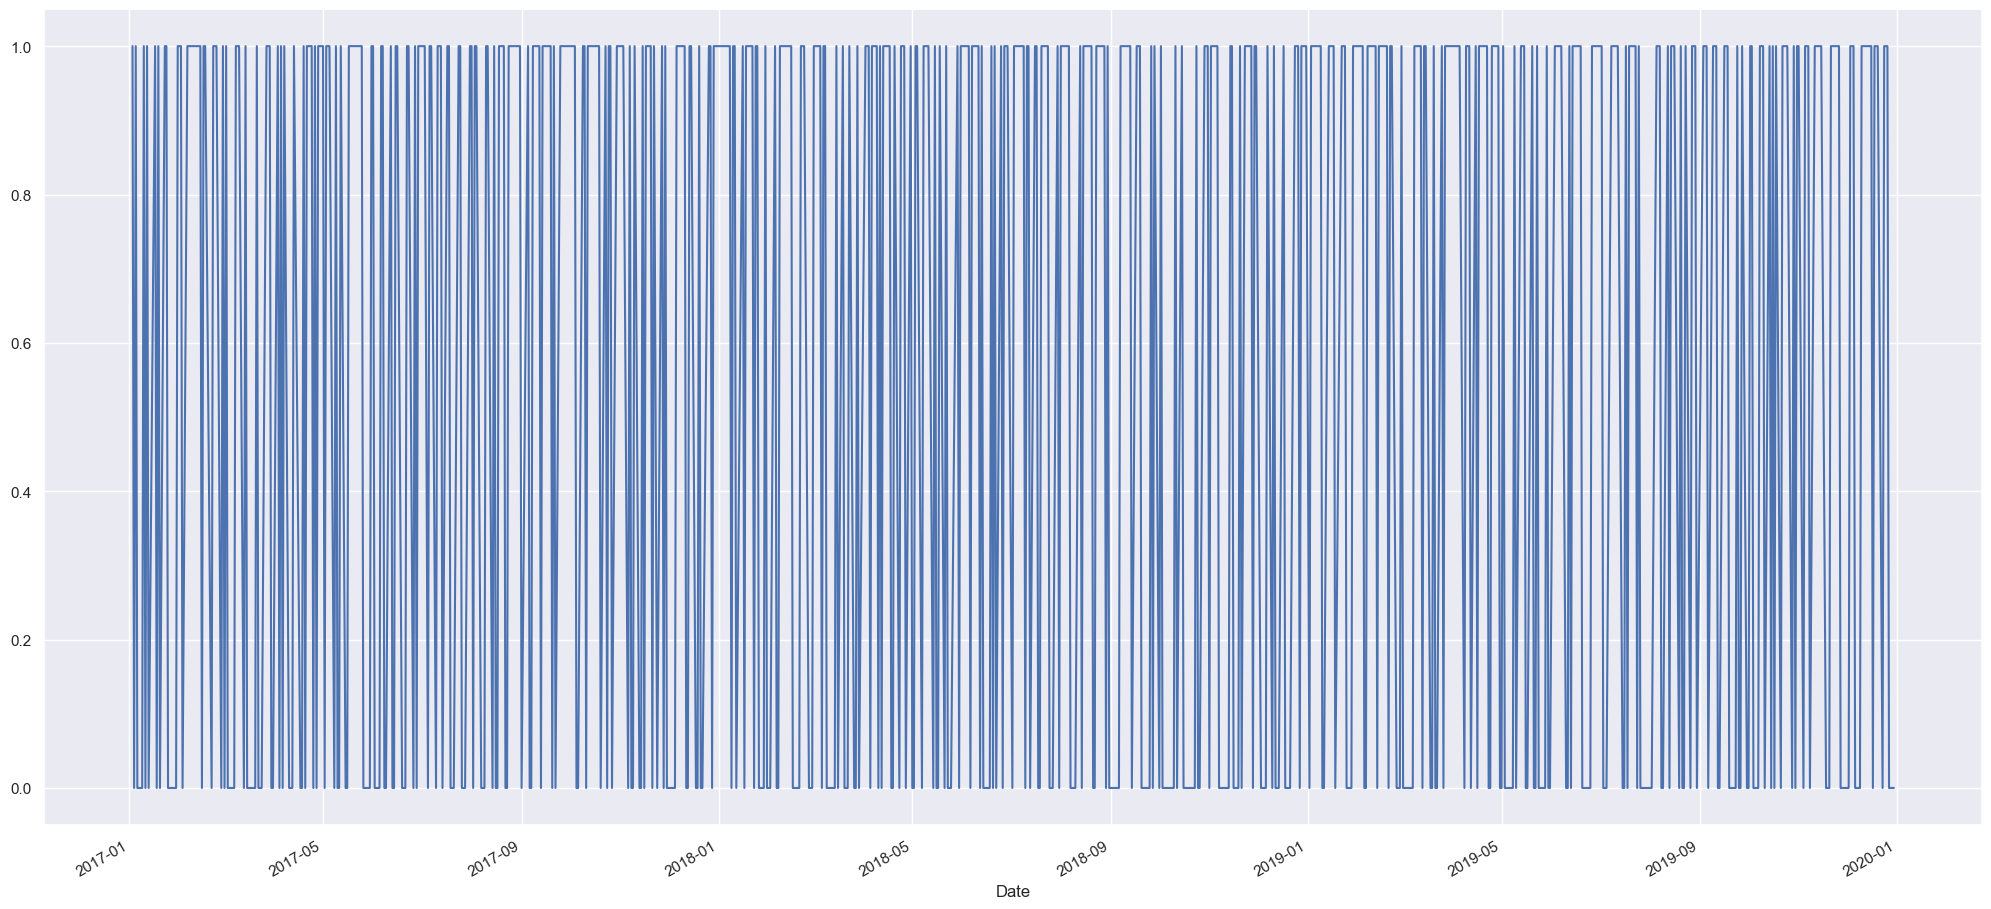

In [78]:
df5['Alvo1_Bin'].plot()

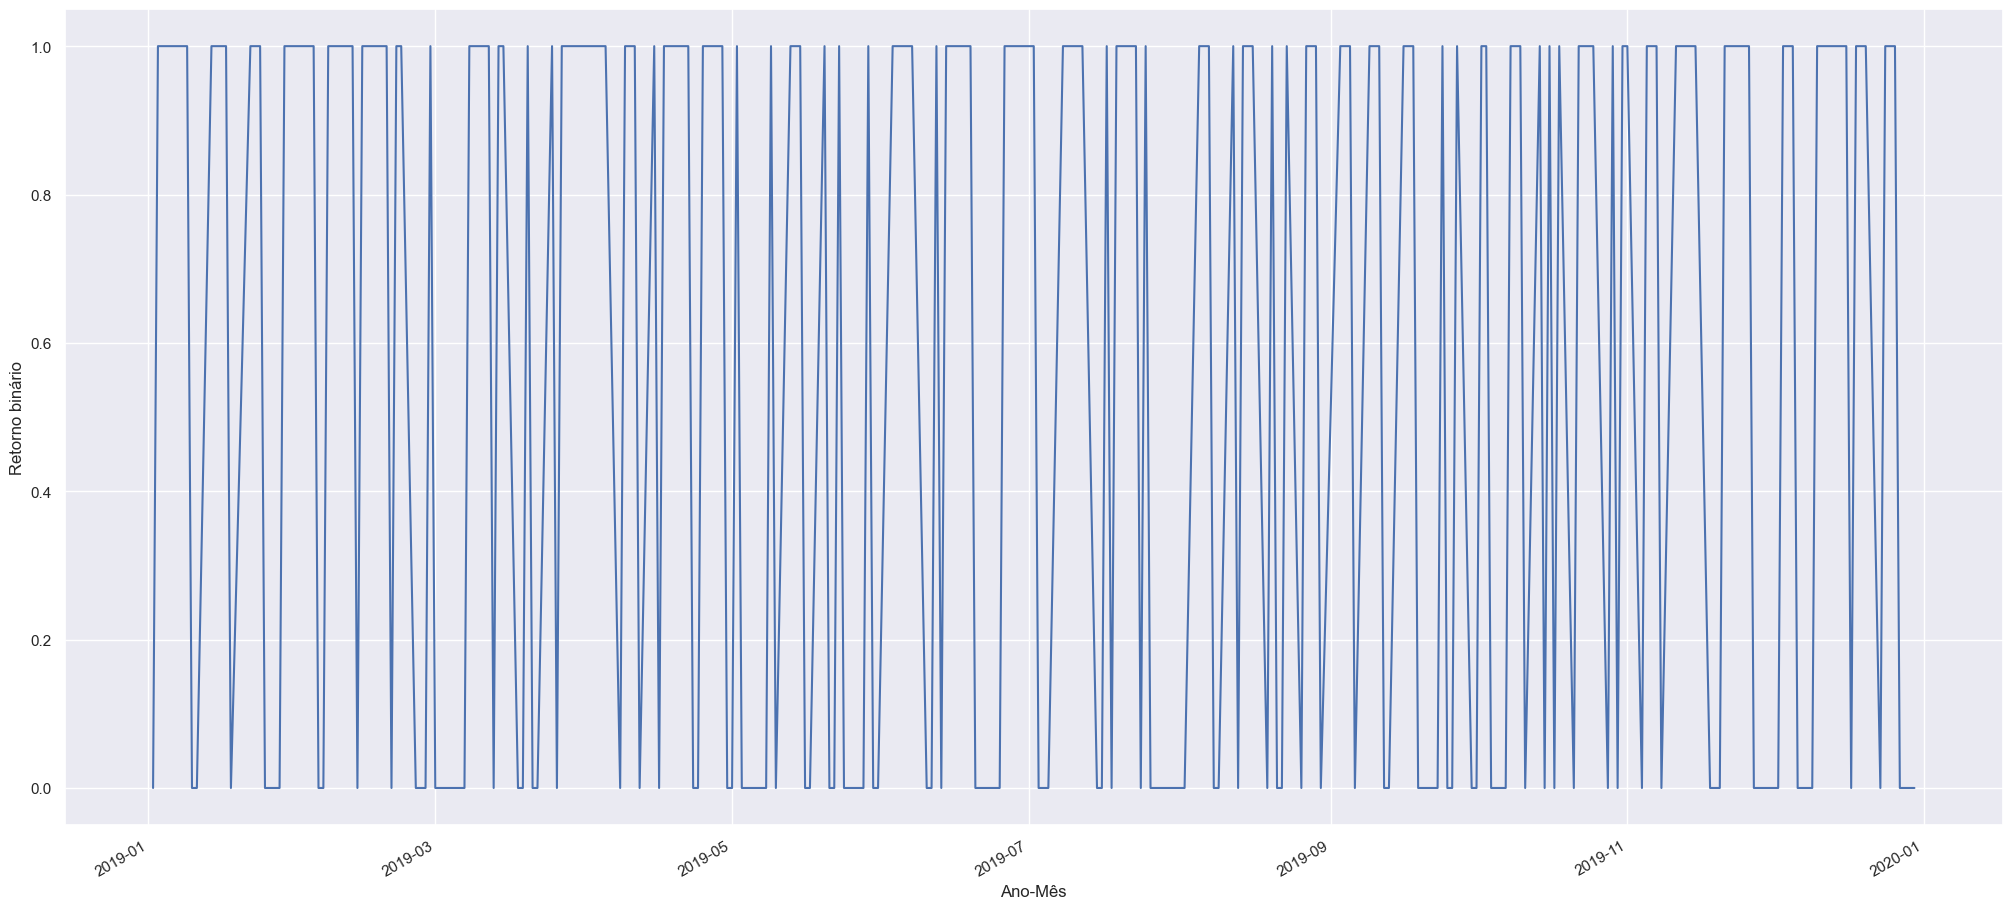

In [81]:
df_alvo = df5['2019-01':'2019-12']
              
df_alvo['Alvo1_Bin'].plot()
plt.ylabel('Retorno binário')
plt.xlabel('Ano-Mês');

In [80]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df5["std5"] = df5["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df5["std10"] = df5["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df5["std15"] = df5["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df5["prop"] = (df5["Close"]-df5["Open"])/(df5["High"]-df5["Low"])

# Direçao do dia atual
df5["dir_D"] = np.where(df5['Close'] > df5['Open'] , '1', '0')

# Direçao D-1
df5["dir_D-1"] = df5["dir_D"].shift(1)

# Direçao D-2
df5["dir_D-2"] = df5["dir_D"].shift(2)

# Direçao D-3
df5["dir_D-3"] = df5["dir_D"].shift(3)

# Media Movel de 15 dias std5
df5["mm_std5"] = df5["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std10"] = df5["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std15"] = df5["std15"].rolling(15).mean()

# RSL std5
df5["RSL_std5"] = df5["std5"]/df5["mm_std5"]

# RSL std10
df5["RSL_std10"] = df5["std10"]/df5["mm_std10"]

# RSL std15
df5["RSL_std15"] = df5["std15"]/df5["mm_std15"]

In [235]:
# Construção das novas variáveis indicados pelo Viola
df5['Variation'] = df5['Close'].diff()
df5 = df5[1:]
df5['Gain'] = np.where(df5['Variation'] > 0, df5['Variation'], 0) 
df5['Loss'] = np.where(df5['Variation'] < 0, df5['Variation'], 0)
n = 14
simple_avg_gain = df5['Gain'].rolling(n).mean()
simple_avg_loss = df5['Loss'].abs().rolling(n).mean()

# start off of simple average series
classic_avg_gain = simple_avg_gain.copy()
classic_avg_loss = simple_avg_loss.copy()

# iterate over the new series but only change values after the nth element
for i in range(n, len(classic_avg_gain)):
    classic_avg_gain[i] = (classic_avg_gain[i - 1] * (n - 1) + df5['Gain'].iloc[i]) / n
    classic_avg_loss[i] = (classic_avg_loss[i - 1] * (n - 1) + df5['Loss'].abs().iloc[i]) / n
    
df5['Simple RS'] = simple_avg_gain / simple_avg_loss
df5['Classic RS'] = classic_avg_gain / classic_avg_loss


df5['Simple RSI'] = 100 - (100 / (1 + df5['Simple RS']))
df5['Classic RSI'] = 100 - (100 / (1 + df5['Classic RS']))

In [236]:
df5.tail()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.006107,0.011127,0.010309,0.170128,1,0,1,1,0.011148,0.012396,0.012307,0.547805,0.897602,0.837688,6.709961,6.709961,0.000000,1.355512,1.585935,57.546389,61.329270
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,4778.729980,3124950000,4793.060059,0,-0.002990,NaN,0,0.006730,0.010281,0.010363,-0.461308,0,1,0,1,0.010845,0.012077,0.012185,0.620551,0.851298,0.850476,-14.330078,0.000000,-14.330078,1.465742,1.481133,59.444254,59.695830


In [237]:
# Filtrando os valores missing

df5_filtrado = df5.dropna( axis = 0 ).reset_index() 

#df5_filtrado= df5_filtrado.drop( ["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1 )

In [238]:
#df5_filtrado["RSL_std5"] = pd.qcut(df5_filtrado["RSL_std5"], 10, labels = False)
#df5_filtrado["RSL_std10"] = pd.qcut(df5_filtrado["RSL_std10"], 10, labels = False)
#df5_filtrado["RSL_std15"] = pd.qcut(df5_filtrado["RSL_std15"], 10, labels = False)

In [239]:
df5_filtrado.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
0,2000-02-14,1387.119995,1394.930054,1380.530029,1389.939941,1389.939941,927300000,1387.119995,1,0.002033,0.008713,1,0.015224,0.011925,0.013983,0.195829,1,0,1,0,0.013996,0.014166,0.014174,1.087800,0.841834,0.986538,2.819946,2.819946,0.000000,0.818156,0.714247,44.999228,41.665354
1,2000-02-15,1389.939941,1407.719971,1376.250000,1402.050049,1402.050049,1092100000,1389.939941,1,0.008713,-0.010256,0,0.014282,0.011745,0.014087,0.384815,1,1,0,1,0.014087,0.014162,0.014039,1.013838,0.829309,1.003464,12.110107,12.110107,0.000000,0.980487,0.821502,49.507361,45.100259
2,2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,1387.670044,1018800000,1402.050049,0,-0.010256,0.000425,1,0.012055,0.012144,0.014293,-0.758036,0,1,1,0,0.014060,0.014219,0.014149,0.857386,0.854073,1.010178,-14.380005,0.000000,-14.380005,0.903960,0.722418,47.477879,41.942100
3,2000-02-17,1387.670044,1399.880005,1380.069946,1388.260010,1388.260010,1034800000,1387.670044,1,0.000425,-0.030376,0,0.011669,0.011340,0.014266,0.029781,1,0,1,1,0.014002,0.014222,0.014254,0.833398,0.797395,1.000828,0.589966,0.589966,0.000000,1.374716,0.727747,57.889708,42.121172
4,2000-02-18,1388.260010,1388.589966,1345.319946,1346.089966,1346.089966,1042300000,1388.260010,0,-0.030376,0.004517,1,0.015285,0.014289,0.014676,-0.974579,0,1,0,1,0.014003,0.014339,0.014266,1.091592,0.996497,1.028733,-42.170044,0.000000,-42.170044,0.587146,0.516055,36.993822,34.039353


In [240]:
df5_filtrado.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
5500,2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.013513,0.011930,0.012006,0.886077,1,1,0,0,0.012790,0.012803,0.012224,1.056588,0.931805,0.982180,47.330078,47.330078,0.000000,1.408844,1.214334,58.486303,54.839686
5501,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809
5502,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473
5503,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656
5504,2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.006107,0.011127,0.010309,0.170128,1,0,1,1,0.011148,0.012396,0.012307,0.547805,0.897602,0.837688,6.709961,6.709961,0.000000,1.355512,1.585935,57.546389,61.329270


In [241]:
df_dollar_euro = pdr.get_data_yahoo( 'EURUSD=X', start=start, end=end )
df_dollar_euro.rename(columns={'Close': 'USDEUR'}, inplace=True)

df_dollar_real = pdr.get_data_yahoo( 'BRL=X', start=start, end=end )['Close'].reset_index()
df_dollar_real.rename(columns={'Close': 'USDBRL'}, inplace=True)

df_oil = pdr.get_data_yahoo( 'CL=F', start=start, end=end )['Close'].reset_index()
df_oil.rename(columns={'Close': 'Oil'}, inplace=True)

df_gold = pdr.get_data_yahoo( 'GC=F', start=start, end=end )['Close'].reset_index()
df_gold.rename(columns={'Close': 'Gold'}, inplace=True)

df_msft = pdr.get_data_yahoo( 'MSFT', start=start, end=end )
df_msft.rename(columns={'Close': 'MSFT'}, inplace=True)

df_aapl = pdr.get_data_yahoo( 'AAPL', start=start, end=end )['Close'].reset_index()
df_aapl.rename(columns={'Close': 'AAPL'}, inplace=True)

df_amzn = pdr.get_data_yahoo( 'AMZN', start=start, end=end )['Close'].reset_index()
df_amzn.rename(columns={'Close': 'AMZN'}, inplace=True)

df_meta = pdr.get_data_yahoo( 'META', start=start, end=end )['Close'].reset_index()
df_meta.rename(columns={'Close': 'META'}, inplace=True)

df_brk = pdr.get_data_yahoo( 'BRK-B', start=start, end=end )['Close'].reset_index()
df_brk.rename(columns={'Close': 'BRK'}, inplace=True)

df_jnj = pdr.get_data_yahoo( 'JNJ', start=start, end=end )['Close'].reset_index()
df_jnj.rename(columns={'Close': 'JNJ'}, inplace=True)

df_visa = pdr.get_data_yahoo( 'V', start=start, end=end )['Close'].reset_index()
df_visa.rename(columns={'Close': 'VISA'}, inplace=True)

df_disney = pdr.get_data_yahoo( 'DIS', start=start, end=end )['Close'].reset_index()
df_disney.rename(columns={'Close': 'DISNEY'}, inplace=True)

df_coke = pdr.get_data_yahoo( 'KO', start=start, end=end )['Close'].reset_index()
df_coke.rename(columns={'Close': 'COKE'}, inplace=True)

df_mcd = pdr.get_data_yahoo( 'MCD', start=start, end=end )['Close'].reset_index()
df_mcd.rename(columns={'Close': 'MCD'}, inplace=True)

df_nike = pdr.get_data_yahoo( 'NKE', start=start, end=end )['Close'].reset_index()
df_nike.rename(columns={'Close': 'NIKE'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [242]:
df_aux1 = df5_filtrado.merge(df_dollar_euro, on='Date').merge(df_dollar_real, on='Date').merge(df_oil, on='Date').merge(df_gold, on='Date')

In [243]:
# df_msft, df_aapl, df_amzn, df_meta, df_brk, df_jnj, df_visa, df_disney, df_coke, df_mcd, df_nike
df_aux1 = df_aux1.merge(df_msft,  on='Date').merge(df_aapl,  on='Date').merge(df_amzn,  on='Date').merge(df_meta,  on='Date').merge(df_brk,  on='Date').merge(df_jnj,  on='Date').merge(df_visa,  on='Date').merge(df_disney,  on='Date').merge(df_coke,  on='Date').merge(df_mcd,  on='Date').merge(df_nike,  on='Date')

In [244]:
df_aux1['USDEUR_Retorno'] = df_aux1['USDEUR'].pct_change( periodos )
df_aux1["USDEUR_Alvo1"] = df_aux1["USDEUR_Retorno"].shift( -periodos )
#df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Alvo1"] > 0 , 1, 0 )
df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Retorno"] > 0 , 1, 0 )

df_aux1['USDBRL_Retorno'] = df_aux1['USDBRL'].pct_change( periodos )
df_aux1["USDBRL_Alvo1"] = df_aux1["USDBRL_Retorno"].shift( -periodos )
#df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Alvo1"] > 0 , 1, 0 )
df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Retorno"] > 0 , 1, 0 )

df_aux1['Oil_Retorno'] = df_aux1['Oil'].pct_change( periodos )
df_aux1["Oil_Alvo1"] = df_aux1["Oil_Retorno"].shift( -periodos )
#df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Alvo1"] > 0 , 1, 0 )
df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Retorno"] > 0 , 1, 0 )

df_aux1['Gold_Retorno'] = df_aux1['Gold'].pct_change( periodos )
df_aux1["Gold_Alvo1"] = df_aux1["Gold_Retorno"].shift( -periodos )
#df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Alvo1"] > 0 , 1, 0 )
df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Retorno"] > 0 , 1, 0 )

df_aux1['msft_Retorno'] = df_aux1['MSFT'].pct_change( periodos )
df_aux1["msft_Alvo1"] = df_aux1["msft_Retorno"].shift( -periodos )
#df_aux1["msft_Bin"] = np.where( df_aux1["msft_Alvo1"] > 0 , 1, 0 )
df_aux1["msft_Bin"] = np.where( df_aux1["msft_Retorno"] > 0 , 1, 0 )

df_aux1['aapl_Retorno'] = df_aux1['AAPL'].pct_change( periodos )
df_aux1["aapl_Alvo1"] = df_aux1["aapl_Retorno"].shift( -periodos )
#df_aux1["aapl_Bin"] = np.where( df_aux1["aapl_Alvo1"] > 0 , 1, 0 )
df_aux1["aapl_Bin"] = np.where( df_aux1["aapl_Retorno"] > 0 , 1, 0 )

df_aux1['amzn_Retorno'] = df_aux1['AMZN'].pct_change( periodos )
df_aux1["amzn_Alvo1"] = df_aux1["amzn_Retorno"].shift( -periodos )
#df_aux1["amzn_Bin"] = np.where( df_aux1["amzn_Alvo1"] > 0 , 1, 0 )
df_aux1["amzn_Bin"] = np.where( df_aux1["amzn_Retorno"] > 0 , 1, 0 )

df_aux1['meta_Retorno'] = df_aux1['META'].pct_change( periodos )
df_aux1["meta_Alvo1"] = df_aux1["meta_Retorno"].shift( -periodos )
#df_aux1["meta_Bin"] = np.where( df_aux1["meta_Alvo1"] > 0 , 1, 0 )
df_aux1["meta_Bin"] = np.where( df_aux1["meta_Retorno"] > 0 , 1, 0 )

df_aux1['brk_Retorno'] = df_aux1['BRK'].pct_change( periodos )
df_aux1["brk_Alvo1"] = df_aux1["brk_Retorno"].shift( -periodos )
#df_aux1["brk_Bin"] = np.where( df_aux1["brk_Alvo1"] > 0 , 1, 0 )
df_aux1["brk_Bin"] = np.where( df_aux1["brk_Retorno"] > 0 , 1, 0 )

df_aux1['jnj_Retorno'] = df_aux1['JNJ'].pct_change( periodos )
df_aux1["jnj_Alvo1"] = df_aux1["jnj_Retorno"].shift( -periodos )
#df_aux1["jnj_Bin"] = np.where( df_aux1["jnj_Alvo1"] > 0 , 1, 0 )
df_aux1["jnj_Bin"] = np.where( df_aux1["jnj_Retorno"] > 0 , 1, 0 )

df_aux1['visa_Retorno'] = df_aux1['VISA'].pct_change( periodos )
df_aux1["visa_Alvo1"] = df_aux1["visa_Retorno"].shift( -periodos )
#df_aux1["visa_Bin"] = np.where( df_aux1["visa_Alvo1"] > 0 , 1, 0 )
df_aux1["visa_Bin"] = np.where( df_aux1["visa_Retorno"] > 0 , 1, 0 )

df_aux1['disney_Retorno'] = df_aux1['DISNEY'].pct_change( periodos )
df_aux1["disney_Alvo1"] = df_aux1["disney_Retorno"].shift( -periodos )
#df_aux1["disney_Bin"] = np.where( df_aux1["disney_Alvo1"] > 0 , 1, 0 )
df_aux1["disney_Bin"] = np.where( df_aux1["disney_Retorno"] > 0 , 1, 0 )

df_aux1['coke_Retorno'] = df_aux1['COKE'].pct_change( periodos )
df_aux1["coke_Alvo1"] = df_aux1["coke_Retorno"].shift( -periodos )
#df_aux1["coke_Bin"] = np.where( df_aux1["coke_Alvo1"] > 0 , 1, 0 )
df_aux1["coke_Bin"] = np.where( df_aux1["coke_Retorno"] > 0 , 1, 0 )

df_aux1['mcd_Retorno'] = df_aux1['MCD'].pct_change( periodos )
df_aux1["mcd_Alvo1"] = df_aux1["mcd_Retorno"].shift( -periodos )
#df_aux1["mcd_Bin"] = np.where( df_aux1["mcd_Alvo1"] > 0 , 1, 0 )
df_aux1["mcd_Bin"] = np.where( df_aux1["mcd_Retorno"] > 0 , 1, 0 )

df_aux1['nike_Retorno'] = df_aux1['NIKE'].pct_change( periodos )
df_aux1["nike_Alvo1"] = df_aux1["nike_Retorno"].shift( -periodos )
#df_aux1["nike_Bin"] = np.where( df_aux1["nike_Alvo1"] > 0 , 1, 0 )
df_aux1["nike_Bin"] = np.where( df_aux1["nike_Retorno"] > 0 , 1, 0 )

In [245]:
df_aux1.head(10)

,Date,Open_x,High_x,Low_x,Close,Adj Close_x,Volume_x,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI,Open_y,High_y,Low_y,USDEUR,Adj Close_y,Volume_y,USDBRL,Oil,Gold,Open,High,Low,MSFT,Adj Close,Volume,AAPL,AMZN,META,BRK,JNJ,VISA,DISNEY,COKE,MCD,NIKE,USDEUR_Retorno,USDEUR_Alvo1,USDEUR_Bin,USDBRL_Retorno,USDBRL_Alvo1,USDBRL_Bin,Oil_Retorno,Oil_Alvo1,Oil_Bin,Gold_Retorno,Gold_Alvo1,Gold_Bin,msft_Retorno,msft_Alvo1,msft_Bin,aapl_Retorno,aapl_Alvo1,aapl_Bin,amzn_Retorno,amzn_Alvo1,amzn_Bin,meta_Retorno,meta_Alvo1,meta_Bin,brk_Retorno,brk_Alvo1,brk_Bin,jnj_Retorno,jnj_Alvo1,jnj_Bin,visa_Retorno,visa_Alvo1,visa_Bin,disney_Retorno,disney_Alvo1,disney_Bin,coke_Retorno,coke_Alvo1,coke_Bin,mcd_Retorno,mcd_Alvo1,mcd_Bin,nike_Retorno,nike_Alvo1,nike_Bin
0,2012-05-18,1305.050049,1312.239990,1291.979980,1295.219971,1295.219971,4512470000,1304.859985,0,-0.007388,0.016036,1,0.004332,0.005093,0.005899,-0.485196,0,0,0,0,0.005771,0.006748,0.007579,0.750602,0.754820,0.778293,-9.640015,0.000000,-9.640015,0.103065,0.302462,9.343522,23.222325,1.269841,1.273983,1.264558,1.269841,1.269841,0,2.0077,91.480003,1591.599976,29.790001,29.809999,29.170000,29.270000,23.721569,56205300,18.942142,10.6925,38.230000,78.910004,63.349998,28.160000,43.810001,37.025002,89.849998,26.360001,NaN,0.005876,0,NaN,0.007123,0,NaN,0.011915,0,NaN,-0.002011,0,NaN,0.016399,0,NaN,0.058260,0,NaN,0.019921,0,NaN,-0.109861,0,NaN,0.011279,0,NaN,0.001894,0,NaN,0.031783,0,NaN,0.013239,0,NaN,0.006212,0,NaN,0.015804,0,NaN,0.016976,0
1,2012-05-21,1295.729980,1316.390015,1295.729980,1315.989990,1315.989990,3786750000,1295.219971,1,0.016036,0.000486,1,0.011575,0.008427,0.008082,0.980638,1,0,0,0,0.006116,0.006772,0.007472,1.892396,1.244403,1.081604,20.770020,20.770020,0.000000,0.215390,0.527330,17.721904,34.526285,1.277302,1.281230,1.273075,1.277302,1.277302,0,2.0220,92.570000,1588.400024,29.100000,29.790001,29.059999,29.750000,24.110569,38787900,20.045713,10.9055,34.029999,79.800003,63.470001,29.055000,44.389999,37.255001,91.269997,26.807501,0.005876,0.002946,1,0.007123,0.005094,1,0.011915,-0.009830,1,-0.002011,-0.007618,0,0.016399,0.000336,1,0.058260,-0.007679,1,0.019921,-0.012746,1,-0.109861,-0.089039,0,0.011279,-0.001880,1,0.001894,0.000788,1,0.031783,0.018671,1,0.013239,0.000000,1,0.006212,-0.004295,1,0.015804,0.000767,1,0.016976,0.011377,1
2,2012-05-22,1316.089966,1328.489990,1310.040039,1316.630005,1316.630005,4123680000,1315.989990,1,0.000486,0.001694,1,0.011582,0.008540,0.007745,0.029270,1,1,0,0,0.006462,0.006891,0.007430,1.792309,1.239203,1.042276,0.640015,0.640015,0.000000,0.227969,0.534793,18.564735,34.844620,1.281394,1.281394,1.274048,1.281066,1.281066,0,2.0323,91.660004,1576.300049,29.690001,29.879999,29.500000,29.760000,24.118679,39504900,19.891787,10.7665,31.000000,79.650002,63.520000,29.597500,44.389999,37.095001,91.339996,27.112499,0.002946,-0.011398,1,0.005094,0.027063,1,-0.009830,-0.019201,0,-0.007618,-0.017890,0,0.000336,-0.021841,1,-0.007679,0.024400,0,-0.012746,0.009056,0,-0.089039,0.032258,0,-0.001880,0.001255,0,0.000788,-0.003936,1,0.018671,0.006588,1,0.000000,-0.004055,0,-0.004295,0.004852,0,0.000767,0.001533,1,0.011377,-0.008575,1
3,2012-05-23,1316.020020,1320.709961,1296.530029,1318.859985,1318.859985,4108330000,1316.630005,1,0.001694,0.001380,1,0.011595,0.008600,0.007890,0.117451,1,1,1,0,0.006919,0.007023,0.007401,1.675769,1.224520,1.066043,2.229980,2.229980,0.000000,0.274641,0.562793,21.546549,36.011996,1.266464,1.268392,1.257008,1.266464,1.266464,0,2.0873,89.900002,1548.099976,29.350000,29.400000,28.639999,29.110001,23.591892,65171000,20.377144,10.8640,32.000000,79.750000,63.270000,29.792500,44.209999,37.275002,91.480003,26.879999,-0.011398,-0.008165,0,0.027063,-0.028841,1,-0.019201,0.008454,0,-0.017890,0.005943,0,-0.021841,-0.001374,0,0.024400,-0.009184,1,0.009056,-0.009389,1,0.032258,0.032187,1,0.0012

In [246]:
# df_msft, df_aapl, df_amzn, df_meta, df_brk, df_jnj, df_visa, df_disney, df_coke, df_mcd, df_nike

In [247]:
df_aux1.tail()

,Date,Open_x,High_x,Low_x,Close,Adj Close_x,Volume_x,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI,Open_y,High_y,Low_y,USDEUR,Adj Close_y,Volume_y,USDBRL,Oil,Gold,Open,High,Low,MSFT,Adj Close,Volume,AAPL,AMZN,META,BRK,JNJ,VISA,DISNEY,COKE,MCD,NIKE,USDEUR_Retorno,USDEUR_Alvo1,USDEUR_Bin,USDBRL_Retorno,USDBRL_Alvo1,USDBRL_Bin,Oil_Retorno,Oil_Alvo1,Oil_Bin,Gold_Retorno,Gold_Alvo1,Gold_Bin,msft_Retorno,msft_Alvo1,msft_Bin,aapl_Retorno,aapl_Alvo1,aapl_Bin,amzn_Retorno,amzn_Alvo1,amzn_Bin,meta_Retorno,meta_Alvo1,meta_Bin,brk_Retorno,brk_Alvo1,brk_Bin,jnj_Retorno,jnj_Alvo1,jnj_Bin,visa_Retorno,visa_Alvo1,visa_Bin,disney_Retorno,disney_Alvo1,disney_Bin,coke_Retorno,coke_Alvo1,coke_Bin,mcd_Retorno,mcd_Alvo1,mcd_Bin,nike_Retorno,nike_Alvo1,nike_Bin
2406,2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.013513,0.011930,0.012006,0.886077,1,1,0,0,0.012790,0.012803,0.012224,1.056588,0.931805,0.982180,47.330078,47.330078,0.000000,1.408844,1.214334,58.486303,54.839686,1.129050,1.134200,1.126532,1.128757,1.128757,0,5.7440,72.760002,1801.599976,328.299988,333.609985,325.750000,333.200012,329.282074,24831500,175.639999,171.037003,330.450012,294.410004,167.929993,217.960007,151.880005,58.180000,264.940002,165.440002,0.000892,0.003659,1,0.000470,-0.015843,1,0.023060,0.014156,1,0.007663,0.005329,1,0.018057,0.004472,1,0.015319,0.003644,1,0.003638,0.000184,1,-0.011221,0.014495,0,0.003990,0.000272,1,0.004306,0.001906,1,0.011979,-0.006148,1,0.005495,0.011522,1,0.007097,0.000688,1,0.002080,0.003812,1,-0.007142,0.001390,0
2407,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809,1.133016,1.134559,1.129152,1.132888,1.132888,0,5.6530,73.790001,1811.199951,332.750000,336.390015,332.730011,334.690002,330.754578,19617800,176.279999,171.068497,335.239990,294.489990,168.250000,216.619995,153.630005,58.220001,265.950012,165.669998,0.003659,-0.000408,1,-0.015843,0.003202,0,0.014156,0.024122,1,0.005329,-0.001712,1,0.004472,0.023186,1,0.003644,0.022975,1,0.000184,-0.008178,1,0.014495,0.032633,1,0.000272,0.007403,1,0.001906,0.008440,1,-0.006148,0.004663,0,0.011522,-0.005403,1,0.000688,0.007386,1,0.003812,0.008611,1,0.001390,0.011529,1
2408,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473,1.132387,1.133500,1.130416,1.132426,1.132426,0,5.6711,75.570000,1808.099976,335.459991,342.480011,335.429993,342.450012,338.423340,19947000,180.330002,169.669495,346.179993,296.670013,169.669998,217.630005,152.800003,58.650002,268.239990,167.580002,-0.000408,0.000510,0,0.003202,-0.008288,1,0.024122,0.005425,1,-0.001712,0.001161,0,0.023186,-0.003504,1,0.022975,-0.005767,1,-0.008178,0.005844,0,0.032633,0.000116,1,0.007403,0.005461,1,0.008440,0.004008,1,0.004663,0.001930,1,-0.005403,0.015707,0,0.007386,0.003922,1,0.008611,-0.001342,1,0.011529,-0.006922,1
2409,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656,1.132978,1.133600,1.129038,1.133003,1.133003,0,5.6241,75.980003,1810.199951,343.149994,343.809998,340.320007,341.250000,337.237457,15661500,179.289993,170.660995,346.220001,298.290009,170.350006,218.050003,155.199997,58.880001,267.880005,166.419998,0.000510,-0.001346,1,-0.

In [248]:
df5.dropna( axis = 0, inplace=True )

# Machine Learning Modelling

In [418]:
df6 = df_aux1.copy()
#df6 = df5_filtrado.copy()

## Split into training and test dataset

In [419]:
print('Menor data: ', df6['Date'].min())
print('Maior data: ', df6['Date'].max())

Menor data:  2012-05-18 00:00:00
Maior data:  2021-12-29 00:00:00


In [420]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2000 à 2017
#start_train = "2000-01-01" #"2000-02-14"
#end_train = "2017-12-31"
start_train = "2017-01-01" #"2000-02-14"
end_train = "2019-06-30"


# Vamos testar o modelo de 2018 à 2019
#start_test = "2018-01-01"
#end_test = "2019-12-31"
start_test = "2019-07-01"
end_test = "2019-12-31"

df6_train1 = df6[(df6['Date'] >= start_train) & (df6['Date'] <= end_train)]

df6_test1 = df6[(df6['Date'] >= start_test) & (df6['Date'] <= end_test)]

In [421]:
df6.columns

Index(['Date', 'Open_x', 'High_x', 'Low_x', 'Close', 'Adj Close_x', 'Volume_x',
       'Lag_P1', 'High_Low', 'Retorno',
       ...
       'disney_Bin', 'coke_Retorno', 'coke_Alvo1', 'coke_Bin', 'mcd_Retorno',
       'mcd_Alvo1', 'mcd_Bin', 'nike_Retorno', 'nike_Alvo1', 'nike_Bin'],
      dtype='object', length=103)

In [422]:
# 'std5','std10','std15','mm_std5','mm_std10','mm_std15'
# 'prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15'
# 'USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin'
# 'msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin'
# 'Simple RSI', 'Classic RSI'

In [423]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df6_train1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15','USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin','msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin']]
y_train1 = df6_train1['Alvo1_Bin']
#y_train1 = df6_train1['Alvo1']


x_test1 = df6_test1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15','USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin','msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin']]
y_test1 = df6_test1['Alvo1_Bin']
#y_test1 = df6_test1['Alvo1']

# Logistic Regression

In [424]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression( random_state=42 ).fit( x_train1, y_train1)
lr_pred = lr_model.predict( x_test1 )

In [425]:
# Teste

print(confusion_matrix( y_test1, lr_pred ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, lr_pred ) )

[[11 40]
 [20 57]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.35      0.22      0.27        51
           1       0.59      0.74      0.66        77

    accuracy                           0.53       128
   macro avg       0.47      0.48      0.46       128
weighted avg       0.49      0.53      0.50       128



In [426]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve( y_test1, lr_pred )
auc( fpr, tpr )

0.4779730073847721

C:\Users\lucas\anaconda3\envs\py_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


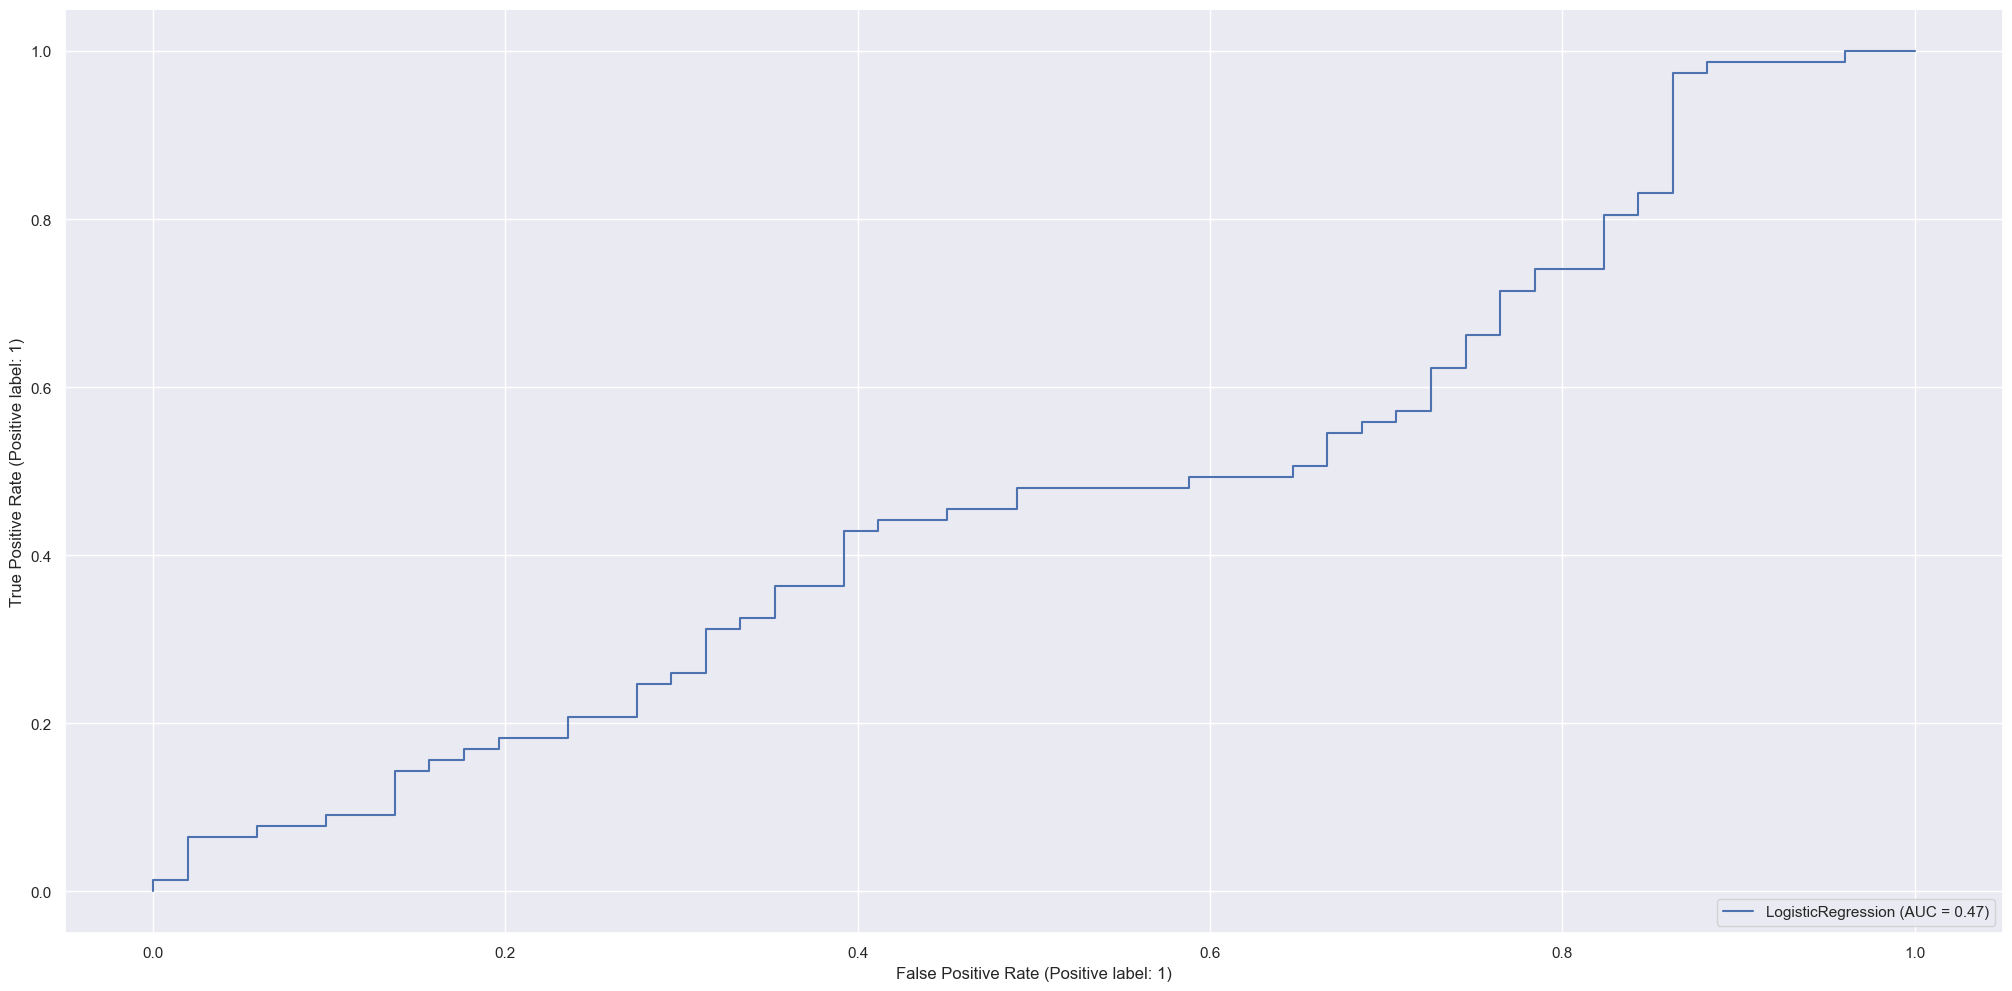

In [427]:
plot_roc_curve(lr_model, x_test1, y_test1)

# Neural Networks

## Feature Scaling

In [428]:
x_train1.head()

,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,USDEUR_Bin,USDBRL_Bin,Oil_Bin,Gold_Bin,msft_Bin,aapl_Bin,amzn_Bin,meta_Bin,brk_Bin,jnj_Bin,visa_Bin,disney_Bin,coke_Bin,mcd_Bin,nike_Bin
1158,0.333867,1,0,0,0,1.396777,0.968607,0.966501,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1
1159,0.815501,1,1,0,0,1.477689,1.033192,1.004032,0,0,1,1,0,0,1,1,1,0,1,1,0,0,1
1160,0.074214,1,1,1,0,1.120295,1.009769,0.944704,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0
1161,0.323729,1,1,1,1,1.114598,1.033378,0.860544,1,0,1,0,1,1,1,1,1,0,1,1,0,1,1
1162,-0.711703,0,1,1,1,1.056801,1.066931,0.880702,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0


In [429]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sc = MinMaxScaler( feature_range = (0, 1) )
#sc = StandardScaler()
x_train1 = sc.fit_transform( x_train1 )

In [430]:
#x_train1

In [431]:
#x_test1 = np.asarray( x_test1 ).astype( np.float32 )
x_test1 = sc.transform( x_test1 )
x_test1 = np.reshape( x_test1, ( x_test1.shape[0], x_test1.shape[1], 1 ) )

## Reshaping

In [432]:
#x_train1.head()

In [433]:
x_train1 = np.asarray( x_train1 ).astype( np.float32 )
x_train1 = np.reshape( x_train1, ( x_train1.shape[0], x_train1.shape[1], 1 ) )

## Initialising the RNN

In [434]:
clf = Sequential()

## Adding the first layer and dropout regularisation

In [435]:
clf.add( LSTM( units = 100, return_sequences = True, input_shape = ( x_train1.shape[1], 1 ), dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a second layer and dropout regularisation

In [436]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a third layer and dropout regularisation

In [437]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a fourth layer and dropout regularisation

In [438]:
clf.add( LSTM( units = 100, activation='relu', dropout=0.2, recurrent_dropout=0.2) )
#clf.add( Dropout( 0.2 ) )

## Adding the output layer and dropout regularisation

In [439]:
clf.add( Dense( units = 1, activation='sigmoid' ) )

## Compiling the RNN

In [440]:
clf.compile( optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics=['accuracy'] )
#clf.compile( optimizer = 'adam', loss = 'mean_squared_error')

## Fitting the RNN

In [441]:
clf.fit( x_train1, y_train1, epochs = 5000, batch_size = 500, shuffle=False, validation_data=(x_test1, y_test1) )

Epoch 1/5000
2/2 [==============================] - 17s 3s/step - loss: 0.6929 - accuracy: 0.4807 - val_loss: 0.6886 - val_accuracy: 0.6016
Epoch 2/5000
2/2 [==============================] - 3s 1s/step - loss: 0.6905 - accuracy: 0.5579 - val_loss: 0.6853 - val_accuracy: 0.6016
Epoch 3/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6890 - accuracy: 0.5579 - val_loss: 0.6824 - val_accuracy: 0.6016
Epoch 4/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6878 - accuracy: 0.5579 - val_loss: 0.6797 - val_accuracy: 0.6016
Epoch 5/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6775 - val_accuracy: 0.6016
Epoch 6/5000
2/2 [==============================] - 3s 1s/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6758 - val_accuracy: 0.6016
Epoch 7/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6748 - val_accuracy: 0.6016
Epoch 8/5000
2/2 [========

2/2 [==============================] - 7s 2s/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 118/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 119/5000
2/2 [==============================] - 6s 2s/step - loss: 0.6869 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 120/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 121/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6873 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 122/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 123/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 124/5000
2/2 [========

2/2 [==============================] - 4s 1s/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 234/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 235/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 236/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 237/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6863 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 238/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6862 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 239/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6872 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 240/5000
2/2 [========

2/2 [==============================] - 4s 1s/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 350/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 351/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 352/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6862 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 353/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6864 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 354/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6857 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 355/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 356/5000
2/2 [========

2/2 [==============================] - 4s 1s/step - loss: 0.6860 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 466/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6861 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 467/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6857 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 468/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 469/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 470/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6858 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 471/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 472/5000
2/2 [========

2/2 [==============================] - 4s 1s/step - loss: 0.6850 - accuracy: 0.5579 - val_loss: 0.6843 - val_accuracy: 0.6016
Epoch 582/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6859 - accuracy: 0.5579 - val_loss: 0.6868 - val_accuracy: 0.6016
Epoch 583/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6837 - accuracy: 0.5579 - val_loss: 0.6874 - val_accuracy: 0.6016
Epoch 584/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6840 - accuracy: 0.5579 - val_loss: 0.6843 - val_accuracy: 0.6016
Epoch 585/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6858 - accuracy: 0.5579 - val_loss: 0.6877 - val_accuracy: 0.6016
Epoch 586/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6855 - accuracy: 0.5579 - val_loss: 0.6851 - val_accuracy: 0.6016
Epoch 587/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6806 - accuracy: 0.5579 - val_loss: 0.6861 - val_accuracy: 0.6016
Epoch 588/5000
2/2 [========

2/2 [==============================] - 4s 1s/step - loss: 0.6825 - accuracy: 0.5547 - val_loss: 0.6941 - val_accuracy: 0.6016
Epoch 698/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6889 - accuracy: 0.5595 - val_loss: 0.6887 - val_accuracy: 0.6016
Epoch 699/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6877 - accuracy: 0.5595 - val_loss: 0.6849 - val_accuracy: 0.6016
Epoch 700/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6948 - accuracy: 0.5563 - val_loss: 0.6877 - val_accuracy: 0.6016
Epoch 701/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6823 - accuracy: 0.5595 - val_loss: 0.6853 - val_accuracy: 0.6016
Epoch 702/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6877 - accuracy: 0.5611 - val_loss: 0.6842 - val_accuracy: 0.6016
Epoch 703/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6874 - accuracy: 0.5579 - val_loss: 0.6873 - val_accuracy: 0.6016
Epoch 704/5000
2/2 [========

2/2 [==============================] - 4s 1s/step - loss: 0.6814 - accuracy: 0.5659 - val_loss: 0.6907 - val_accuracy: 0.5938
Epoch 814/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6855 - accuracy: 0.5579 - val_loss: 0.6921 - val_accuracy: 0.6094
Epoch 815/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6866 - accuracy: 0.5547 - val_loss: 0.6891 - val_accuracy: 0.6094
Epoch 816/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6825 - accuracy: 0.5756 - val_loss: 0.6932 - val_accuracy: 0.6016
Epoch 817/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6840 - accuracy: 0.5579 - val_loss: 0.6943 - val_accuracy: 0.6016
Epoch 818/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6917 - accuracy: 0.5547 - val_loss: 0.6911 - val_accuracy: 0.6016
Epoch 819/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6861 - accuracy: 0.5531 - val_loss: 0.6902 - val_accuracy: 0.5859
Epoch 820/5000
2/2 [========

2/2 [==============================] - 7s 2s/step - loss: 0.6893 - accuracy: 0.5643 - val_loss: 0.6941 - val_accuracy: 0.5938
Epoch 930/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6865 - accuracy: 0.5595 - val_loss: 0.6914 - val_accuracy: 0.6016
Epoch 931/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6878 - accuracy: 0.5547 - val_loss: 0.6905 - val_accuracy: 0.5938
Epoch 932/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6879 - accuracy: 0.5675 - val_loss: 0.6891 - val_accuracy: 0.5938
Epoch 933/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6842 - accuracy: 0.5675 - val_loss: 0.6886 - val_accuracy: 0.6016
Epoch 934/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6825 - accuracy: 0.5611 - val_loss: 0.6927 - val_accuracy: 0.6016
Epoch 935/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6907 - accuracy: 0.5547 - val_loss: 0.6906 - val_accuracy: 0.5859
Epoch 936/5000
2/2 [========

Epoch 1045/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6843 - accuracy: 0.5595 - val_loss: 0.6917 - val_accuracy: 0.6016
Epoch 1046/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6858 - accuracy: 0.5627 - val_loss: 0.6931 - val_accuracy: 0.6016
Epoch 1047/5000
2/2 [==============================] - 7s 3s/step - loss: 0.6786 - accuracy: 0.5659 - val_loss: 0.6948 - val_accuracy: 0.6016
Epoch 1048/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6825 - accuracy: 0.5611 - val_loss: 0.6966 - val_accuracy: 0.5938
Epoch 1049/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6887 - accuracy: 0.5514 - val_loss: 0.6936 - val_accuracy: 0.5938
Epoch 1050/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6854 - accuracy: 0.5579 - val_loss: 0.6931 - val_accuracy: 0.5938
Epoch 1051/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6899 - accuracy: 0.5691 - val_loss: 0.6927 - val_accuracy: 0.6094
Epoch 

Epoch 1103/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6868 - accuracy: 0.5498 - val_loss: 0.6935 - val_accuracy: 0.5781
Epoch 1104/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6897 - accuracy: 0.5675 - val_loss: 0.6982 - val_accuracy: 0.5859
Epoch 1105/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6861 - accuracy: 0.5563 - val_loss: 0.6993 - val_accuracy: 0.5781
Epoch 1106/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6861 - accuracy: 0.5514 - val_loss: 0.6986 - val_accuracy: 0.5859
Epoch 1107/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6800 - accuracy: 0.5611 - val_loss: 0.6995 - val_accuracy: 0.5938
Epoch 1108/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6879 - accuracy: 0.5611 - val_loss: 0.7017 - val_accuracy: 0.5938
Epoch 1109/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6866 - accuracy: 0.5434 - val_loss: 0.7009 - val_accuracy: 0.6016
Epoch 

Epoch 1161/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6865 - accuracy: 0.5531 - val_loss: 0.6947 - val_accuracy: 0.5938
Epoch 1162/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6852 - accuracy: 0.5579 - val_loss: 0.6932 - val_accuracy: 0.5859
Epoch 1163/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6879 - accuracy: 0.5611 - val_loss: 0.6953 - val_accuracy: 0.5859
Epoch 1164/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6864 - accuracy: 0.5498 - val_loss: 0.6981 - val_accuracy: 0.6016
Epoch 1165/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6855 - accuracy: 0.5547 - val_loss: 0.6979 - val_accuracy: 0.6016
Epoch 1166/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6866 - accuracy: 0.5579 - val_loss: 0.6957 - val_accuracy: 0.5703
Epoch 1167/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6850 - accuracy: 0.5659 - val_loss: 0.6952 - val_accuracy: 0.5938
Epoch 

Epoch 1219/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6807 - accuracy: 0.5643 - val_loss: 0.6950 - val_accuracy: 0.5781
Epoch 1220/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6853 - accuracy: 0.5563 - val_loss: 0.6978 - val_accuracy: 0.6016
Epoch 1221/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6870 - accuracy: 0.5643 - val_loss: 0.6936 - val_accuracy: 0.5938
Epoch 1222/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6808 - accuracy: 0.5531 - val_loss: 0.7017 - val_accuracy: 0.5781
Epoch 1223/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6934 - accuracy: 0.5466 - val_loss: 0.6964 - val_accuracy: 0.5859
Epoch 1224/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6914 - accuracy: 0.5418 - val_loss: 0.6976 - val_accuracy: 0.6016
Epoch 1225/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6859 - accuracy: 0.5547 - val_loss: 0.6967 - val_accuracy: 0.5938
Epoch 

Epoch 1277/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6867 - accuracy: 0.5434 - val_loss: 0.6938 - val_accuracy: 0.6016
Epoch 1278/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6922 - accuracy: 0.5595 - val_loss: 0.6916 - val_accuracy: 0.6016
Epoch 1279/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6851 - accuracy: 0.5611 - val_loss: 0.6918 - val_accuracy: 0.5938
Epoch 1280/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6818 - accuracy: 0.5756 - val_loss: 0.6979 - val_accuracy: 0.5859
Epoch 1281/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6874 - accuracy: 0.5402 - val_loss: 0.6905 - val_accuracy: 0.5938
Epoch 1282/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6823 - accuracy: 0.5691 - val_loss: 0.6930 - val_accuracy: 0.6016
Epoch 1283/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6843 - accuracy: 0.5466 - val_loss: 0.6930 - val_accuracy: 0.6094
Epoch 

Epoch 1335/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6847 - accuracy: 0.5579 - val_loss: 0.6984 - val_accuracy: 0.6016
Epoch 1336/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6898 - accuracy: 0.5514 - val_loss: 0.6985 - val_accuracy: 0.6016
Epoch 1337/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6810 - accuracy: 0.5691 - val_loss: 0.7017 - val_accuracy: 0.6016
Epoch 1338/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6943 - accuracy: 0.5579 - val_loss: 0.6878 - val_accuracy: 0.5938
Epoch 1339/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6918 - accuracy: 0.5627 - val_loss: 0.6966 - val_accuracy: 0.6016
Epoch 1340/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6819 - accuracy: 0.5563 - val_loss: 0.6995 - val_accuracy: 0.5859
Epoch 1341/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6782 - accuracy: 0.5643 - val_loss: 0.7070 - val_accuracy: 0.5547
Epoch 

Epoch 1393/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6823 - accuracy: 0.5675 - val_loss: 0.7027 - val_accuracy: 0.5938
Epoch 1394/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6888 - accuracy: 0.5531 - val_loss: 0.7040 - val_accuracy: 0.5859
Epoch 1395/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6842 - accuracy: 0.5707 - val_loss: 0.6996 - val_accuracy: 0.6016
Epoch 1396/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6825 - accuracy: 0.5595 - val_loss: 0.7025 - val_accuracy: 0.5547
Epoch 1397/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6877 - accuracy: 0.5402 - val_loss: 0.7002 - val_accuracy: 0.6016
Epoch 1398/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.7012 - val_accuracy: 0.6016
Epoch 1399/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6870 - accuracy: 0.5740 - val_loss: 0.6983 - val_accuracy: 0.6016
Epoch 

Epoch 1451/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6833 - accuracy: 0.5740 - val_loss: 0.6964 - val_accuracy: 0.6094
Epoch 1452/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6769 - accuracy: 0.5836 - val_loss: 0.6989 - val_accuracy: 0.6016
Epoch 1453/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6851 - accuracy: 0.5643 - val_loss: 0.7062 - val_accuracy: 0.5469
Epoch 1454/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6971 - accuracy: 0.5241 - val_loss: 0.6963 - val_accuracy: 0.6094
Epoch 1455/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6833 - accuracy: 0.5595 - val_loss: 0.6941 - val_accuracy: 0.5938
Epoch 1456/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6872 - accuracy: 0.5563 - val_loss: 0.6936 - val_accuracy: 0.6094
Epoch 1457/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6849 - accuracy: 0.5611 - val_loss: 0.6953 - val_accuracy: 0.6094
Epoch 

Epoch 1509/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6823 - accuracy: 0.5707 - val_loss: 0.6943 - val_accuracy: 0.5781
Epoch 1510/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6813 - accuracy: 0.5579 - val_loss: 0.6957 - val_accuracy: 0.5938
Epoch 1511/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6864 - accuracy: 0.5531 - val_loss: 0.6938 - val_accuracy: 0.6016
Epoch 1512/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6869 - accuracy: 0.5675 - val_loss: 0.6910 - val_accuracy: 0.6016
Epoch 1513/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6875 - accuracy: 0.5466 - val_loss: 0.6968 - val_accuracy: 0.6016
Epoch 1514/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6891 - accuracy: 0.5498 - val_loss: 0.6941 - val_accuracy: 0.6016
Epoch 1515/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6863 - accuracy: 0.5643 - val_loss: 0.6933 - val_accuracy: 0.6016
Epoch 

Epoch 1624/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6843 - accuracy: 0.5691 - val_loss: 0.6980 - val_accuracy: 0.6016
Epoch 1625/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6906 - accuracy: 0.5402 - val_loss: 0.6967 - val_accuracy: 0.6094
Epoch 1626/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6775 - accuracy: 0.5756 - val_loss: 0.6974 - val_accuracy: 0.5938
Epoch 1627/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6839 - accuracy: 0.5756 - val_loss: 0.7002 - val_accuracy: 0.5938
Epoch 1628/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6921 - accuracy: 0.5450 - val_loss: 0.6942 - val_accuracy: 0.5938
Epoch 1629/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6861 - accuracy: 0.5579 - val_loss: 0.7007 - val_accuracy: 0.5859
Epoch 1630/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6903 - accuracy: 0.5531 - val_loss: 0.6949 - val_accuracy: 0.5938
Epoch 

Epoch 1682/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6874 - accuracy: 0.5579 - val_loss: 0.7045 - val_accuracy: 0.6016
Epoch 1683/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6792 - accuracy: 0.5691 - val_loss: 0.7072 - val_accuracy: 0.5938
Epoch 1684/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6936 - accuracy: 0.5547 - val_loss: 0.7009 - val_accuracy: 0.5859
Epoch 1685/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6792 - accuracy: 0.5740 - val_loss: 0.7041 - val_accuracy: 0.5859
Epoch 1686/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6846 - accuracy: 0.5547 - val_loss: 0.7040 - val_accuracy: 0.5938
Epoch 1687/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6814 - accuracy: 0.5659 - val_loss: 0.7026 - val_accuracy: 0.6016
Epoch 1688/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6806 - accuracy: 0.5723 - val_loss: 0.7023 - val_accuracy: 0.5859
Epoch 

Epoch 1740/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6895 - accuracy: 0.5514 - val_loss: 0.6988 - val_accuracy: 0.6094
Epoch 1741/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6817 - accuracy: 0.5563 - val_loss: 0.7020 - val_accuracy: 0.5859
Epoch 1742/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6846 - accuracy: 0.5627 - val_loss: 0.7039 - val_accuracy: 0.6016
Epoch 1743/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6835 - accuracy: 0.5466 - val_loss: 0.6980 - val_accuracy: 0.6016
Epoch 1744/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6907 - accuracy: 0.5595 - val_loss: 0.6997 - val_accuracy: 0.5938
Epoch 1745/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6871 - accuracy: 0.5627 - val_loss: 0.7010 - val_accuracy: 0.5938
Epoch 1746/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6773 - accuracy: 0.5788 - val_loss: 0.7005 - val_accuracy: 0.6094
Epoch 

Epoch 1798/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6858 - accuracy: 0.5659 - val_loss: 0.7000 - val_accuracy: 0.5938
Epoch 1799/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6897 - accuracy: 0.5434 - val_loss: 0.7009 - val_accuracy: 0.5938
Epoch 1800/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6826 - accuracy: 0.5579 - val_loss: 0.7032 - val_accuracy: 0.6016
Epoch 1801/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6917 - accuracy: 0.5563 - val_loss: 0.7019 - val_accuracy: 0.6016
Epoch 1802/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6911 - accuracy: 0.5482 - val_loss: 0.7008 - val_accuracy: 0.6016
Epoch 1803/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6860 - accuracy: 0.5659 - val_loss: 0.7003 - val_accuracy: 0.6016
Epoch 1804/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6854 - accuracy: 0.5627 - val_loss: 0.6990 - val_accuracy: 0.6016
Epoch 

Epoch 1856/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6821 - accuracy: 0.5788 - val_loss: 0.7007 - val_accuracy: 0.6016
Epoch 1857/5000
2/2 [==============================] - 9s 3s/step - loss: 0.6879 - accuracy: 0.5482 - val_loss: 0.6983 - val_accuracy: 0.5859
Epoch 1858/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6914 - accuracy: 0.5531 - val_loss: 0.6998 - val_accuracy: 0.5938
Epoch 1859/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6880 - accuracy: 0.5691 - val_loss: 0.7007 - val_accuracy: 0.6016
Epoch 1860/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6849 - accuracy: 0.5595 - val_loss: 0.6994 - val_accuracy: 0.6094
Epoch 1861/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6852 - accuracy: 0.5627 - val_loss: 0.7008 - val_accuracy: 0.6094
Epoch 1862/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6855 - accuracy: 0.5482 - val_loss: 0.7000 - val_accuracy: 0.6016
Epoch 

Epoch 1914/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6819 - accuracy: 0.5788 - val_loss: 0.7011 - val_accuracy: 0.5938
Epoch 1915/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6847 - accuracy: 0.5498 - val_loss: 0.7037 - val_accuracy: 0.6094
Epoch 1916/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6847 - accuracy: 0.5579 - val_loss: 0.7029 - val_accuracy: 0.6094
Epoch 1917/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6855 - accuracy: 0.5643 - val_loss: 0.7022 - val_accuracy: 0.5859
Epoch 1918/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6886 - accuracy: 0.5466 - val_loss: 0.6998 - val_accuracy: 0.6094
Epoch 1919/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6900 - accuracy: 0.5514 - val_loss: 0.7010 - val_accuracy: 0.6016
Epoch 1920/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6884 - accuracy: 0.5691 - val_loss: 0.6983 - val_accuracy: 0.6016
Epoch 

Epoch 1972/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6843 - accuracy: 0.5643 - val_loss: 0.7017 - val_accuracy: 0.5938
Epoch 1973/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6842 - accuracy: 0.5563 - val_loss: 0.7015 - val_accuracy: 0.6094
Epoch 1974/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6842 - accuracy: 0.5659 - val_loss: 0.7056 - val_accuracy: 0.6094
Epoch 1975/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6851 - accuracy: 0.5595 - val_loss: 0.7050 - val_accuracy: 0.6016
Epoch 1976/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6887 - accuracy: 0.5563 - val_loss: 0.7056 - val_accuracy: 0.6016
Epoch 1977/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6860 - accuracy: 0.5563 - val_loss: 0.7069 - val_accuracy: 0.6016
Epoch 1978/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6937 - accuracy: 0.5498 - val_loss: 0.6961 - val_accuracy: 0.6016
Epoch 

Epoch 2030/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6876 - accuracy: 0.5482 - val_loss: 0.6985 - val_accuracy: 0.6016
Epoch 2031/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6816 - accuracy: 0.5772 - val_loss: 0.7017 - val_accuracy: 0.5859
Epoch 2032/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6838 - accuracy: 0.5627 - val_loss: 0.6997 - val_accuracy: 0.6094
Epoch 2033/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6807 - accuracy: 0.5772 - val_loss: 0.7009 - val_accuracy: 0.6094
Epoch 2034/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6789 - accuracy: 0.5627 - val_loss: 0.6991 - val_accuracy: 0.6016
Epoch 2035/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6922 - accuracy: 0.5498 - val_loss: 0.6997 - val_accuracy: 0.5938
Epoch 2036/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.7000 - val_accuracy: 0.6016
Epoch 

Epoch 2088/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6915 - accuracy: 0.5579 - val_loss: 0.6976 - val_accuracy: 0.6016
Epoch 2089/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6855 - accuracy: 0.5531 - val_loss: 0.6996 - val_accuracy: 0.5938
Epoch 2090/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6841 - accuracy: 0.5627 - val_loss: 0.7011 - val_accuracy: 0.6016
Epoch 2091/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6770 - accuracy: 0.5820 - val_loss: 0.7054 - val_accuracy: 0.6094
Epoch 2092/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6874 - accuracy: 0.5386 - val_loss: 0.7044 - val_accuracy: 0.6094
Epoch 2093/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6795 - accuracy: 0.5788 - val_loss: 0.7058 - val_accuracy: 0.6094
Epoch 2094/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6921 - accuracy: 0.5450 - val_loss: 0.7045 - val_accuracy: 0.6016
Epoch 

Epoch 2146/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6883 - accuracy: 0.5547 - val_loss: 0.7101 - val_accuracy: 0.6016
Epoch 2147/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6800 - accuracy: 0.5675 - val_loss: 0.7053 - val_accuracy: 0.6172
Epoch 2148/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6918 - accuracy: 0.5370 - val_loss: 0.7052 - val_accuracy: 0.6016
Epoch 2149/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6826 - accuracy: 0.5804 - val_loss: 0.7068 - val_accuracy: 0.6094
Epoch 2150/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6826 - accuracy: 0.5740 - val_loss: 0.7115 - val_accuracy: 0.6094
Epoch 2151/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6870 - accuracy: 0.5514 - val_loss: 0.7091 - val_accuracy: 0.5781
Epoch 2152/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6914 - accuracy: 0.5322 - val_loss: 0.7078 - val_accuracy: 0.5938
Epoch 

Epoch 2204/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6848 - accuracy: 0.5579 - val_loss: 0.7043 - val_accuracy: 0.6016
Epoch 2205/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6861 - accuracy: 0.5547 - val_loss: 0.7110 - val_accuracy: 0.6016
Epoch 2206/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6806 - accuracy: 0.5707 - val_loss: 0.7130 - val_accuracy: 0.6016
Epoch 2207/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6896 - accuracy: 0.5482 - val_loss: 0.7143 - val_accuracy: 0.5859
Epoch 2208/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6873 - accuracy: 0.5804 - val_loss: 0.7043 - val_accuracy: 0.6016
Epoch 2209/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6964 - accuracy: 0.5498 - val_loss: 0.7114 - val_accuracy: 0.6016
Epoch 2210/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6895 - accuracy: 0.5579 - val_loss: 0.7107 - val_accuracy: 0.6016
Epoch 

Epoch 2262/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6913 - accuracy: 0.5547 - val_loss: 0.7131 - val_accuracy: 0.5938
Epoch 2263/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6828 - accuracy: 0.5386 - val_loss: 0.7109 - val_accuracy: 0.6016
Epoch 2264/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6894 - accuracy: 0.5611 - val_loss: 0.6981 - val_accuracy: 0.5859
Epoch 2265/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6855 - accuracy: 0.5707 - val_loss: 0.7090 - val_accuracy: 0.6016
Epoch 2266/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6839 - accuracy: 0.5579 - val_loss: 0.7023 - val_accuracy: 0.6016
Epoch 2267/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6920 - accuracy: 0.5466 - val_loss: 0.7016 - val_accuracy: 0.5938
Epoch 2268/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6859 - accuracy: 0.5482 - val_loss: 0.7027 - val_accuracy: 0.6016
Epoch 

Epoch 2320/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6846 - accuracy: 0.5836 - val_loss: 0.7161 - val_accuracy: 0.5859
Epoch 2321/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6905 - accuracy: 0.5386 - val_loss: 0.7115 - val_accuracy: 0.6094
Epoch 2322/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6824 - accuracy: 0.5675 - val_loss: 0.7124 - val_accuracy: 0.5859
Epoch 2323/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6945 - accuracy: 0.5514 - val_loss: 0.7116 - val_accuracy: 0.6094
Epoch 2324/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6850 - accuracy: 0.5723 - val_loss: 0.7087 - val_accuracy: 0.6016
Epoch 2325/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6825 - accuracy: 0.5611 - val_loss: 0.7099 - val_accuracy: 0.6016
Epoch 2326/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6851 - accuracy: 0.5611 - val_loss: 0.7151 - val_accuracy: 0.5703
Epoch 

Epoch 2378/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6873 - accuracy: 0.5804 - val_loss: 0.7189 - val_accuracy: 0.6016
Epoch 2379/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6752 - accuracy: 0.5804 - val_loss: 0.7208 - val_accuracy: 0.6016
Epoch 2380/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6894 - accuracy: 0.5402 - val_loss: 0.7121 - val_accuracy: 0.6094
Epoch 2381/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6879 - accuracy: 0.5675 - val_loss: 0.7188 - val_accuracy: 0.6016
Epoch 2382/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6836 - accuracy: 0.5514 - val_loss: 0.7072 - val_accuracy: 0.6016
Epoch 2383/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6883 - accuracy: 0.5691 - val_loss: 0.7135 - val_accuracy: 0.5859
Epoch 2384/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6894 - accuracy: 0.5563 - val_loss: 0.7165 - val_accuracy: 0.6016
Epoch 

Epoch 2436/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6705 - accuracy: 0.5804 - val_loss: 0.7269 - val_accuracy: 0.6016
Epoch 2437/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6887 - accuracy: 0.5756 - val_loss: 0.6947 - val_accuracy: 0.6016
Epoch 2438/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6799 - accuracy: 0.5691 - val_loss: 0.7237 - val_accuracy: 0.6016
Epoch 2439/5000
2/2 [==============================] - 9s 3s/step - loss: 0.6905 - accuracy: 0.5595 - val_loss: 0.7130 - val_accuracy: 0.6094
Epoch 2440/5000
2/2 [==============================] - 9s 3s/step - loss: 0.6840 - accuracy: 0.5579 - val_loss: 0.6978 - val_accuracy: 0.5938
Epoch 2441/5000
2/2 [==============================] - 9s 3s/step - loss: 0.6848 - accuracy: 0.5659 - val_loss: 0.7144 - val_accuracy: 0.5938
Epoch 2442/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6899 - accuracy: 0.5643 - val_loss: 0.7257 - val_accuracy: 0.6016
Epoch 

Epoch 2494/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6965 - accuracy: 0.5691 - val_loss: 0.7237 - val_accuracy: 0.6016
Epoch 2495/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6778 - accuracy: 0.5691 - val_loss: 0.7237 - val_accuracy: 0.5703
Epoch 2496/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6805 - accuracy: 0.5579 - val_loss: 0.7170 - val_accuracy: 0.5938
Epoch 2497/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6856 - accuracy: 0.5659 - val_loss: 0.7333 - val_accuracy: 0.5781
Epoch 2498/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6934 - accuracy: 0.5563 - val_loss: 0.7195 - val_accuracy: 0.5859
Epoch 2499/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6790 - accuracy: 0.5691 - val_loss: 0.7390 - val_accuracy: 0.5859
Epoch 2500/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6679 - accuracy: 0.5884 - val_loss: 0.7457 - val_accuracy: 0.5859
Epoch 

Epoch 2552/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6794 - accuracy: 0.5868 - val_loss: 0.7236 - val_accuracy: 0.5469
Epoch 2553/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6659 - accuracy: 0.5740 - val_loss: 0.7306 - val_accuracy: 0.5781
Epoch 2554/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6852 - accuracy: 0.5643 - val_loss: 0.7214 - val_accuracy: 0.6172
Epoch 2555/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6805 - accuracy: 0.5852 - val_loss: 0.7124 - val_accuracy: 0.5859
Epoch 2556/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6808 - accuracy: 0.5659 - val_loss: 0.7105 - val_accuracy: 0.6016
Epoch 2557/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6852 - accuracy: 0.5627 - val_loss: 0.7202 - val_accuracy: 0.5938
Epoch 2558/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6842 - accuracy: 0.5740 - val_loss: 0.7022 - val_accuracy: 0.5938
Epoch 

Epoch 2610/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6857 - accuracy: 0.5531 - val_loss: 0.7124 - val_accuracy: 0.6016
Epoch 2611/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6920 - accuracy: 0.5659 - val_loss: 0.7267 - val_accuracy: 0.5703
Epoch 2612/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6820 - accuracy: 0.5675 - val_loss: 0.7336 - val_accuracy: 0.5859
Epoch 2613/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6779 - accuracy: 0.5756 - val_loss: 0.7306 - val_accuracy: 0.5859
Epoch 2614/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6851 - accuracy: 0.5627 - val_loss: 0.7296 - val_accuracy: 0.6016
Epoch 2615/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6878 - accuracy: 0.5531 - val_loss: 0.7150 - val_accuracy: 0.5859
Epoch 2616/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6814 - accuracy: 0.5723 - val_loss: 0.7435 - val_accuracy: 0.6016
Epoch 

Epoch 2668/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6836 - accuracy: 0.5691 - val_loss: 0.7431 - val_accuracy: 0.5781
Epoch 2669/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6920 - accuracy: 0.5740 - val_loss: 0.7430 - val_accuracy: 0.5547
Epoch 2670/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6870 - accuracy: 0.5691 - val_loss: 0.7504 - val_accuracy: 0.5703
Epoch 2671/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6846 - accuracy: 0.5675 - val_loss: 0.7429 - val_accuracy: 0.5469
Epoch 2672/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6920 - accuracy: 0.5627 - val_loss: 0.7224 - val_accuracy: 0.5859
Epoch 2673/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6749 - accuracy: 0.5788 - val_loss: 0.7289 - val_accuracy: 0.5469
Epoch 2674/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6729 - accuracy: 0.5707 - val_loss: 0.7513 - val_accuracy: 0.5781
Epoch 

Epoch 2726/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6857 - accuracy: 0.5675 - val_loss: 0.7319 - val_accuracy: 0.5703
Epoch 2727/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6756 - accuracy: 0.5852 - val_loss: 0.7323 - val_accuracy: 0.5781
Epoch 2728/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6714 - accuracy: 0.5772 - val_loss: 0.7512 - val_accuracy: 0.5625
Epoch 2729/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6895 - accuracy: 0.5820 - val_loss: 0.7451 - val_accuracy: 0.5781
Epoch 2730/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6800 - accuracy: 0.5595 - val_loss: 0.7338 - val_accuracy: 0.5781
Epoch 2731/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6762 - accuracy: 0.5740 - val_loss: 0.7330 - val_accuracy: 0.5703
Epoch 2732/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6782 - accuracy: 0.5740 - val_loss: 0.7441 - val_accuracy: 0.5938
Epoch 

Epoch 2784/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6912 - accuracy: 0.5740 - val_loss: 0.7265 - val_accuracy: 0.5547
Epoch 2785/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6751 - accuracy: 0.5868 - val_loss: 0.7500 - val_accuracy: 0.5781
Epoch 2786/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6770 - accuracy: 0.5563 - val_loss: 0.7343 - val_accuracy: 0.5781
Epoch 2787/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6757 - accuracy: 0.5868 - val_loss: 0.7437 - val_accuracy: 0.5703
Epoch 2788/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6872 - accuracy: 0.5514 - val_loss: 0.7498 - val_accuracy: 0.5703
Epoch 2789/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6881 - accuracy: 0.5643 - val_loss: 0.7283 - val_accuracy: 0.5781
Epoch 2790/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6923 - accuracy: 0.5740 - val_loss: 0.7117 - val_accuracy: 0.6094
Epoch 

Epoch 2842/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6885 - accuracy: 0.5740 - val_loss: 0.7396 - val_accuracy: 0.5312
Epoch 2843/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6785 - accuracy: 0.5675 - val_loss: 0.7188 - val_accuracy: 0.6016
Epoch 2844/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6822 - accuracy: 0.5723 - val_loss: 0.7496 - val_accuracy: 0.5547
Epoch 2845/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6791 - accuracy: 0.5852 - val_loss: 0.7265 - val_accuracy: 0.5781
Epoch 2846/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6605 - accuracy: 0.5836 - val_loss: 0.7569 - val_accuracy: 0.5938
Epoch 2847/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6834 - accuracy: 0.5868 - val_loss: 0.7322 - val_accuracy: 0.5938
Epoch 2848/5000
2/2 [==============================] - 8s 2s/step - loss: 0.7003 - accuracy: 0.5466 - val_loss: 0.7437 - val_accuracy: 0.5938
Epoch 

Epoch 2900/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6674 - accuracy: 0.5772 - val_loss: 0.7488 - val_accuracy: 0.5469
Epoch 2901/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6501 - accuracy: 0.5981 - val_loss: 0.7491 - val_accuracy: 0.5547
Epoch 2902/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6905 - accuracy: 0.5643 - val_loss: 0.7550 - val_accuracy: 0.5547
Epoch 2903/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6739 - accuracy: 0.5884 - val_loss: 0.7427 - val_accuracy: 0.5391
Epoch 2904/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6715 - accuracy: 0.5852 - val_loss: 0.7729 - val_accuracy: 0.5469
Epoch 2905/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6780 - accuracy: 0.5932 - val_loss: 0.7467 - val_accuracy: 0.5469
Epoch 2906/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6607 - accuracy: 0.6174 - val_loss: 0.7502 - val_accuracy: 0.5391
Epoch 

Epoch 2958/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6850 - accuracy: 0.5804 - val_loss: 0.7364 - val_accuracy: 0.5703
Epoch 2959/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6743 - accuracy: 0.5852 - val_loss: 0.7258 - val_accuracy: 0.5781
Epoch 2960/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6790 - accuracy: 0.5900 - val_loss: 0.7467 - val_accuracy: 0.5703
Epoch 2961/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6635 - accuracy: 0.6029 - val_loss: 0.7382 - val_accuracy: 0.5859
Epoch 2962/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6879 - accuracy: 0.5820 - val_loss: 0.7463 - val_accuracy: 0.5703
Epoch 2963/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6616 - accuracy: 0.5932 - val_loss: 0.7465 - val_accuracy: 0.5703
Epoch 2964/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6661 - accuracy: 0.5965 - val_loss: 0.7476 - val_accuracy: 0.5703
Epoch 

Epoch 3016/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6572 - accuracy: 0.5884 - val_loss: 0.7434 - val_accuracy: 0.5469
Epoch 3017/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6697 - accuracy: 0.5949 - val_loss: 0.7854 - val_accuracy: 0.5156
Epoch 3018/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6771 - accuracy: 0.5643 - val_loss: 0.7372 - val_accuracy: 0.5703
Epoch 3019/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6700 - accuracy: 0.5884 - val_loss: 0.7580 - val_accuracy: 0.5547
Epoch 3020/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6706 - accuracy: 0.6077 - val_loss: 0.7393 - val_accuracy: 0.5547
Epoch 3021/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6845 - accuracy: 0.5756 - val_loss: 0.7493 - val_accuracy: 0.5156
Epoch 3022/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6750 - accuracy: 0.5949 - val_loss: 0.7460 - val_accuracy: 0.5156
Epoch 

Epoch 3074/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6667 - accuracy: 0.5756 - val_loss: 0.7480 - val_accuracy: 0.5391
Epoch 3075/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6484 - accuracy: 0.6431 - val_loss: 0.7788 - val_accuracy: 0.4922
Epoch 3076/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6806 - accuracy: 0.5579 - val_loss: 0.7695 - val_accuracy: 0.5156
Epoch 3077/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6614 - accuracy: 0.5981 - val_loss: 0.7719 - val_accuracy: 0.5234
Epoch 3078/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6714 - accuracy: 0.6045 - val_loss: 0.7579 - val_accuracy: 0.5234
Epoch 3079/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6765 - accuracy: 0.5852 - val_loss: 0.7266 - val_accuracy: 0.5312
Epoch 3080/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6750 - accuracy: 0.5852 - val_loss: 0.7602 - val_accuracy: 0.5156
Epoch 

Epoch 3132/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6691 - accuracy: 0.5900 - val_loss: 0.7259 - val_accuracy: 0.5625
Epoch 3133/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6658 - accuracy: 0.5916 - val_loss: 0.7365 - val_accuracy: 0.5547
Epoch 3134/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6630 - accuracy: 0.5965 - val_loss: 0.7814 - val_accuracy: 0.5234
Epoch 3135/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6830 - accuracy: 0.5691 - val_loss: 0.7413 - val_accuracy: 0.5469
Epoch 3136/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6762 - accuracy: 0.6141 - val_loss: 0.7562 - val_accuracy: 0.5469
Epoch 3137/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6755 - accuracy: 0.5820 - val_loss: 0.7544 - val_accuracy: 0.5391
Epoch 3138/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6588 - accuracy: 0.5949 - val_loss: 0.7595 - val_accuracy: 0.5312
Epoch 

Epoch 3190/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6591 - accuracy: 0.6061 - val_loss: 0.7788 - val_accuracy: 0.5156
Epoch 3191/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6824 - accuracy: 0.6029 - val_loss: 0.7952 - val_accuracy: 0.5312
Epoch 3192/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6741 - accuracy: 0.5820 - val_loss: 0.7357 - val_accuracy: 0.5234
Epoch 3193/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6539 - accuracy: 0.6125 - val_loss: 0.7785 - val_accuracy: 0.5000
Epoch 3194/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6528 - accuracy: 0.6109 - val_loss: 0.7633 - val_accuracy: 0.5469
Epoch 3195/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6575 - accuracy: 0.6190 - val_loss: 0.7963 - val_accuracy: 0.5469
Epoch 3196/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6622 - accuracy: 0.6029 - val_loss: 0.7953 - val_accuracy: 0.5547
Epoch 

Epoch 3248/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6474 - accuracy: 0.6399 - val_loss: 0.7877 - val_accuracy: 0.5234
Epoch 3249/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6762 - accuracy: 0.6174 - val_loss: 0.7875 - val_accuracy: 0.5234
Epoch 3250/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6584 - accuracy: 0.6286 - val_loss: 0.7846 - val_accuracy: 0.5234
Epoch 3251/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6568 - accuracy: 0.6093 - val_loss: 0.7929 - val_accuracy: 0.5156
Epoch 3252/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6541 - accuracy: 0.6141 - val_loss: 0.7886 - val_accuracy: 0.5469
Epoch 3253/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6766 - accuracy: 0.6141 - val_loss: 0.7925 - val_accuracy: 0.5234
Epoch 3254/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6509 - accuracy: 0.6077 - val_loss: 0.7260 - val_accuracy: 0.5781
Epoch 

Epoch 3306/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6616 - accuracy: 0.6206 - val_loss: 0.8347 - val_accuracy: 0.5312
Epoch 3307/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6665 - accuracy: 0.6061 - val_loss: 0.8269 - val_accuracy: 0.5312
Epoch 3308/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6326 - accuracy: 0.6383 - val_loss: 0.8015 - val_accuracy: 0.5391
Epoch 3309/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6529 - accuracy: 0.6302 - val_loss: 0.8136 - val_accuracy: 0.5625
Epoch 3310/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6902 - accuracy: 0.6045 - val_loss: 0.7989 - val_accuracy: 0.5078
Epoch 3311/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6564 - accuracy: 0.6415 - val_loss: 0.8150 - val_accuracy: 0.5000
Epoch 3312/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6662 - accuracy: 0.6206 - val_loss: 0.7867 - val_accuracy: 0.5156
Epoch 

Epoch 3364/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6503 - accuracy: 0.5997 - val_loss: 0.8432 - val_accuracy: 0.4922
Epoch 3365/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6436 - accuracy: 0.6302 - val_loss: 0.8533 - val_accuracy: 0.5391
Epoch 3366/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6667 - accuracy: 0.6158 - val_loss: 0.8377 - val_accuracy: 0.4922
Epoch 3367/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6491 - accuracy: 0.6077 - val_loss: 0.8223 - val_accuracy: 0.5469
Epoch 3368/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6474 - accuracy: 0.6270 - val_loss: 0.8366 - val_accuracy: 0.4844
Epoch 3369/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6387 - accuracy: 0.6399 - val_loss: 0.8330 - val_accuracy: 0.4375
Epoch 3370/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6334 - accuracy: 0.6350 - val_loss: 0.8915 - val_accuracy: 0.4922
Epoch 

Epoch 3422/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6276 - accuracy: 0.6656 - val_loss: 0.8520 - val_accuracy: 0.5078
Epoch 3423/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6318 - accuracy: 0.6415 - val_loss: 0.8271 - val_accuracy: 0.5234
Epoch 3424/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6716 - accuracy: 0.6061 - val_loss: 0.8570 - val_accuracy: 0.5078
Epoch 3425/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6345 - accuracy: 0.6286 - val_loss: 0.8331 - val_accuracy: 0.5156
Epoch 3426/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6478 - accuracy: 0.6238 - val_loss: 0.8696 - val_accuracy: 0.4922
Epoch 3427/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6217 - accuracy: 0.6608 - val_loss: 0.8921 - val_accuracy: 0.5078
Epoch 3428/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6196 - accuracy: 0.6479 - val_loss: 0.9231 - val_accuracy: 0.4766
Epoch 

Epoch 3480/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6356 - accuracy: 0.6367 - val_loss: 0.8752 - val_accuracy: 0.5156
Epoch 3481/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6686 - accuracy: 0.6318 - val_loss: 0.8874 - val_accuracy: 0.4766
Epoch 3482/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6288 - accuracy: 0.6383 - val_loss: 0.8614 - val_accuracy: 0.4609
Epoch 3483/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6269 - accuracy: 0.6431 - val_loss: 0.9090 - val_accuracy: 0.4297
Epoch 3484/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6354 - accuracy: 0.6109 - val_loss: 0.8776 - val_accuracy: 0.5000
Epoch 3485/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6274 - accuracy: 0.6447 - val_loss: 0.8948 - val_accuracy: 0.5391
Epoch 3486/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6424 - accuracy: 0.6527 - val_loss: 0.8920 - val_accuracy: 0.4922
Epoch 

Epoch 3538/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6695 - accuracy: 0.6190 - val_loss: 0.9118 - val_accuracy: 0.4844
Epoch 3539/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6323 - accuracy: 0.6286 - val_loss: 0.9060 - val_accuracy: 0.5000
Epoch 3540/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6096 - accuracy: 0.6559 - val_loss: 0.9247 - val_accuracy: 0.5078
Epoch 3541/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6336 - accuracy: 0.6559 - val_loss: 0.9220 - val_accuracy: 0.4453
Epoch 3542/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6426 - accuracy: 0.6190 - val_loss: 0.9260 - val_accuracy: 0.4766
Epoch 3543/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6104 - accuracy: 0.6704 - val_loss: 0.9152 - val_accuracy: 0.4844
Epoch 3544/5000
2/2 [==============================] - 8s 2s/step - loss: 0.6148 - accuracy: 0.6463 - val_loss: 0.9157 - val_accuracy: 0.4766
Epoch 

Epoch 3596/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5897 - accuracy: 0.6656 - val_loss: 0.9133 - val_accuracy: 0.4844
Epoch 3597/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6309 - accuracy: 0.6624 - val_loss: 0.9289 - val_accuracy: 0.5000
Epoch 3598/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6140 - accuracy: 0.6527 - val_loss: 0.9393 - val_accuracy: 0.5312
Epoch 3599/5000
2/2 [==============================] - 7s 2s/step - loss: 0.5999 - accuracy: 0.6768 - val_loss: 0.9209 - val_accuracy: 0.5000
Epoch 3600/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6099 - accuracy: 0.6559 - val_loss: 0.9335 - val_accuracy: 0.4844
Epoch 3601/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6098 - accuracy: 0.6383 - val_loss: 0.8668 - val_accuracy: 0.4766
Epoch 3602/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6638 - accuracy: 0.6254 - val_loss: 0.8829 - val_accuracy: 0.4453
Epoch 

Epoch 3654/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6106 - accuracy: 0.6801 - val_loss: 0.9624 - val_accuracy: 0.4844
Epoch 3655/5000
2/2 [==============================] - 5s 1s/step - loss: 0.5957 - accuracy: 0.6897 - val_loss: 0.9859 - val_accuracy: 0.4922
Epoch 3656/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5905 - accuracy: 0.6752 - val_loss: 0.8803 - val_accuracy: 0.5078
Epoch 3657/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6170 - accuracy: 0.6383 - val_loss: 0.9994 - val_accuracy: 0.4219
Epoch 3658/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6120 - accuracy: 0.6383 - val_loss: 1.0129 - val_accuracy: 0.4609
Epoch 3659/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6260 - accuracy: 0.6592 - val_loss: 1.0087 - val_accuracy: 0.4453
Epoch 3660/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5843 - accuracy: 0.6752 - val_loss: 0.9870 - val_accuracy: 0.4844
Epoch 

Epoch 3769/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5837 - accuracy: 0.7042 - val_loss: 1.0881 - val_accuracy: 0.4688
Epoch 3770/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5621 - accuracy: 0.7219 - val_loss: 1.1057 - val_accuracy: 0.4844
Epoch 3771/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5643 - accuracy: 0.7138 - val_loss: 0.9300 - val_accuracy: 0.4688
Epoch 3772/5000
2/2 [==============================] - 8s 3s/step - loss: 0.6014 - accuracy: 0.6865 - val_loss: 1.0177 - val_accuracy: 0.4609
Epoch 3773/5000
2/2 [==============================] - 9s 3s/step - loss: 0.5850 - accuracy: 0.7154 - val_loss: 1.0667 - val_accuracy: 0.3984
Epoch 3774/5000
2/2 [==============================] - 9s 3s/step - loss: 0.6067 - accuracy: 0.6849 - val_loss: 1.0096 - val_accuracy: 0.4375
Epoch 3775/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5689 - accuracy: 0.6865 - val_loss: 1.0451 - val_accuracy: 0.4219
Epoch 

Epoch 3827/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5413 - accuracy: 0.7122 - val_loss: 1.0916 - val_accuracy: 0.5000
Epoch 3828/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5805 - accuracy: 0.6913 - val_loss: 1.1235 - val_accuracy: 0.4609
Epoch 3829/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5595 - accuracy: 0.7138 - val_loss: 1.1378 - val_accuracy: 0.4844
Epoch 3830/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5317 - accuracy: 0.7138 - val_loss: 1.2749 - val_accuracy: 0.4844
Epoch 3831/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5900 - accuracy: 0.6977 - val_loss: 1.2428 - val_accuracy: 0.5000
Epoch 3832/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5898 - accuracy: 0.6817 - val_loss: 1.0545 - val_accuracy: 0.4766
Epoch 3833/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5452 - accuracy: 0.6977 - val_loss: 1.0397 - val_accuracy: 0.5078
Epoch 

Epoch 3885/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5512 - accuracy: 0.7347 - val_loss: 1.1267 - val_accuracy: 0.5000
Epoch 3886/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5152 - accuracy: 0.7154 - val_loss: 1.1434 - val_accuracy: 0.4844
Epoch 3887/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5214 - accuracy: 0.7315 - val_loss: 1.2038 - val_accuracy: 0.4609
Epoch 3888/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5725 - accuracy: 0.6945 - val_loss: 1.2081 - val_accuracy: 0.4688
Epoch 3889/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5110 - accuracy: 0.7476 - val_loss: 1.3794 - val_accuracy: 0.5078
Epoch 3890/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5139 - accuracy: 0.7653 - val_loss: 1.2998 - val_accuracy: 0.5000
Epoch 3891/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5096 - accuracy: 0.7460 - val_loss: 1.2018 - val_accuracy: 0.5234
Epoch 

Epoch 3943/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5143 - accuracy: 0.7412 - val_loss: 1.2483 - val_accuracy: 0.4922
Epoch 3944/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5632 - accuracy: 0.7010 - val_loss: 1.1956 - val_accuracy: 0.4609
Epoch 3945/5000
2/2 [==============================] - 9s 3s/step - loss: 0.5062 - accuracy: 0.7524 - val_loss: 1.0867 - val_accuracy: 0.4609
Epoch 3946/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5573 - accuracy: 0.7042 - val_loss: 1.1422 - val_accuracy: 0.4453
Epoch 3947/5000
2/2 [==============================] - 9s 3s/step - loss: 0.5437 - accuracy: 0.7428 - val_loss: 1.2442 - val_accuracy: 0.4609
Epoch 3948/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5334 - accuracy: 0.7106 - val_loss: 1.1934 - val_accuracy: 0.4609
Epoch 3949/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5149 - accuracy: 0.7251 - val_loss: 1.2455 - val_accuracy: 0.4766
Epoch 

Epoch 4001/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5040 - accuracy: 0.7444 - val_loss: 1.3697 - val_accuracy: 0.4688
Epoch 4002/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4651 - accuracy: 0.7846 - val_loss: 1.3142 - val_accuracy: 0.4922
Epoch 4003/5000
2/2 [==============================] - 8s 2s/step - loss: 0.4518 - accuracy: 0.7733 - val_loss: 1.5983 - val_accuracy: 0.5469
Epoch 4004/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5290 - accuracy: 0.7476 - val_loss: 1.2306 - val_accuracy: 0.4766
Epoch 4005/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5026 - accuracy: 0.7717 - val_loss: 1.1864 - val_accuracy: 0.5156
Epoch 4006/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5315 - accuracy: 0.7460 - val_loss: 1.1832 - val_accuracy: 0.5078
Epoch 4007/5000
2/2 [==============================] - 9s 3s/step - loss: 0.5020 - accuracy: 0.7379 - val_loss: 1.3786 - val_accuracy: 0.5156
Epoch 

Epoch 4059/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4851 - accuracy: 0.7524 - val_loss: 1.2841 - val_accuracy: 0.4688
Epoch 4060/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5139 - accuracy: 0.7347 - val_loss: 1.2613 - val_accuracy: 0.4766
Epoch 4061/5000
2/2 [==============================] - 8s 2s/step - loss: 0.5177 - accuracy: 0.7412 - val_loss: 1.0543 - val_accuracy: 0.4609
Epoch 4062/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5234 - accuracy: 0.7379 - val_loss: 1.3167 - val_accuracy: 0.5078
Epoch 4063/5000
2/2 [==============================] - 8s 2s/step - loss: 0.4781 - accuracy: 0.7669 - val_loss: 1.3239 - val_accuracy: 0.5234
Epoch 4064/5000
2/2 [==============================] - 8s 2s/step - loss: 0.4994 - accuracy: 0.7846 - val_loss: 1.2086 - val_accuracy: 0.5078
Epoch 4065/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4500 - accuracy: 0.7862 - val_loss: 1.3046 - val_accuracy: 0.5078
Epoch 

Epoch 4117/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4494 - accuracy: 0.7797 - val_loss: 1.6163 - val_accuracy: 0.4766
Epoch 4118/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4783 - accuracy: 0.7556 - val_loss: 1.3283 - val_accuracy: 0.4844
Epoch 4119/5000
2/2 [==============================] - 9s 3s/step - loss: 0.4866 - accuracy: 0.7556 - val_loss: 1.4337 - val_accuracy: 0.4922
Epoch 4120/5000
2/2 [==============================] - 9s 3s/step - loss: 0.4422 - accuracy: 0.7942 - val_loss: 1.4491 - val_accuracy: 0.5156
Epoch 4121/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4070 - accuracy: 0.8119 - val_loss: 1.2211 - val_accuracy: 0.4844
Epoch 4122/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4780 - accuracy: 0.7637 - val_loss: 1.4100 - val_accuracy: 0.5391
Epoch 4123/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4922 - accuracy: 0.7444 - val_loss: 1.2791 - val_accuracy: 0.5156
Epoch 

Epoch 4175/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4378 - accuracy: 0.8006 - val_loss: 1.5360 - val_accuracy: 0.5000
Epoch 4176/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4228 - accuracy: 0.8103 - val_loss: 1.3648 - val_accuracy: 0.4844
Epoch 4177/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4152 - accuracy: 0.7990 - val_loss: 1.5201 - val_accuracy: 0.4844
Epoch 4178/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4370 - accuracy: 0.8103 - val_loss: 1.6280 - val_accuracy: 0.4844
Epoch 4179/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4413 - accuracy: 0.7910 - val_loss: 1.4204 - val_accuracy: 0.4688
Epoch 4180/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4369 - accuracy: 0.7846 - val_loss: 1.7276 - val_accuracy: 0.5000
Epoch 4181/5000
2/2 [==============================] - 7s 2s/step - loss: 0.4440 - accuracy: 0.7765 - val_loss: 1.6102 - val_accuracy: 0.4766
Epoch 

Epoch 4233/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4097 - accuracy: 0.8039 - val_loss: 1.4637 - val_accuracy: 0.4453
Epoch 4234/5000
2/2 [==============================] - 5s 2s/step - loss: 0.4656 - accuracy: 0.7958 - val_loss: 1.3673 - val_accuracy: 0.4844
Epoch 4235/5000
2/2 [==============================] - 5s 2s/step - loss: 0.4283 - accuracy: 0.7990 - val_loss: 1.4869 - val_accuracy: 0.4453
Epoch 4236/5000
2/2 [==============================] - 5s 2s/step - loss: 0.4215 - accuracy: 0.8087 - val_loss: 1.4803 - val_accuracy: 0.5078
Epoch 4237/5000
2/2 [==============================] - 5s 2s/step - loss: 0.4107 - accuracy: 0.7974 - val_loss: 1.4905 - val_accuracy: 0.4766
Epoch 4238/5000
2/2 [==============================] - 5s 2s/step - loss: 0.3824 - accuracy: 0.8183 - val_loss: 1.4059 - val_accuracy: 0.5156
Epoch 4239/5000
2/2 [==============================] - 6s 2s/step - loss: 0.4368 - accuracy: 0.7926 - val_loss: 1.4982 - val_accuracy: 0.5312
Epoch 

Epoch 4348/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3555 - accuracy: 0.8264 - val_loss: 1.5232 - val_accuracy: 0.5000
Epoch 4349/5000
2/2 [==============================] - 8s 3s/step - loss: 0.5056 - accuracy: 0.7846 - val_loss: 1.4296 - val_accuracy: 0.5312
Epoch 4350/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3736 - accuracy: 0.8215 - val_loss: 1.5529 - val_accuracy: 0.4922
Epoch 4351/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3921 - accuracy: 0.8248 - val_loss: 1.6567 - val_accuracy: 0.5156
Epoch 4352/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3972 - accuracy: 0.8199 - val_loss: 1.5339 - val_accuracy: 0.5000
Epoch 4353/5000
2/2 [==============================] - 8s 3s/step - loss: 0.4064 - accuracy: 0.8248 - val_loss: 1.4119 - val_accuracy: 0.5000
Epoch 4354/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3627 - accuracy: 0.8360 - val_loss: 1.7146 - val_accuracy: 0.4922
Epoch 

Epoch 4406/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3187 - accuracy: 0.8505 - val_loss: 1.5911 - val_accuracy: 0.5078
Epoch 4407/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3443 - accuracy: 0.8408 - val_loss: 1.6284 - val_accuracy: 0.4766
Epoch 4408/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3805 - accuracy: 0.8312 - val_loss: 1.4278 - val_accuracy: 0.5000
Epoch 4409/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3620 - accuracy: 0.8473 - val_loss: 1.5238 - val_accuracy: 0.5312
Epoch 4410/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3983 - accuracy: 0.8151 - val_loss: 1.5588 - val_accuracy: 0.4766
Epoch 4411/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3393 - accuracy: 0.8521 - val_loss: 1.6680 - val_accuracy: 0.4844
Epoch 4412/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3329 - accuracy: 0.8537 - val_loss: 1.6293 - val_accuracy: 0.4922
Epoch 

Epoch 4464/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3259 - accuracy: 0.8505 - val_loss: 1.7497 - val_accuracy: 0.5234
Epoch 4465/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3402 - accuracy: 0.8489 - val_loss: 2.1491 - val_accuracy: 0.4922
Epoch 4466/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3185 - accuracy: 0.8601 - val_loss: 2.1460 - val_accuracy: 0.5000
Epoch 4467/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3039 - accuracy: 0.8810 - val_loss: 4.0194 - val_accuracy: 0.5078
Epoch 4468/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3669 - accuracy: 0.8473 - val_loss: 1.8061 - val_accuracy: 0.4922
Epoch 4469/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3063 - accuracy: 0.8650 - val_loss: 1.8274 - val_accuracy: 0.5078
Epoch 4470/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3640 - accuracy: 0.8248 - val_loss: 1.7009 - val_accuracy: 0.5312
Epoch 

Epoch 4522/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3376 - accuracy: 0.8505 - val_loss: 1.7353 - val_accuracy: 0.5469
Epoch 4523/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3269 - accuracy: 0.8537 - val_loss: 1.6435 - val_accuracy: 0.5312
Epoch 4524/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3407 - accuracy: 0.8489 - val_loss: 1.5506 - val_accuracy: 0.5625
Epoch 4525/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3187 - accuracy: 0.8650 - val_loss: 1.4261 - val_accuracy: 0.5469
Epoch 4526/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3441 - accuracy: 0.8441 - val_loss: 1.3899 - val_accuracy: 0.5391
Epoch 4527/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3464 - accuracy: 0.8360 - val_loss: 1.5686 - val_accuracy: 0.5391
Epoch 4528/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3064 - accuracy: 0.8714 - val_loss: 1.7312 - val_accuracy: 0.5000
Epoch 

Epoch 4580/5000
2/2 [==============================] - 8s 2s/step - loss: 0.2933 - accuracy: 0.8875 - val_loss: 1.7331 - val_accuracy: 0.4844
Epoch 4581/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3239 - accuracy: 0.8617 - val_loss: 1.6049 - val_accuracy: 0.4844
Epoch 4582/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3477 - accuracy: 0.8489 - val_loss: 1.7193 - val_accuracy: 0.5078
Epoch 4583/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3164 - accuracy: 0.8650 - val_loss: 1.7689 - val_accuracy: 0.5078
Epoch 4584/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2771 - accuracy: 0.8859 - val_loss: 1.8397 - val_accuracy: 0.5000
Epoch 4585/5000
2/2 [==============================] - 8s 2s/step - loss: 0.3230 - accuracy: 0.8521 - val_loss: 1.9991 - val_accuracy: 0.5391
Epoch 4586/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2491 - accuracy: 0.9019 - val_loss: 2.0420 - val_accuracy: 0.5312
Epoch 

Epoch 4638/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2823 - accuracy: 0.8826 - val_loss: 1.8416 - val_accuracy: 0.5312
Epoch 4639/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2982 - accuracy: 0.8875 - val_loss: 1.9233 - val_accuracy: 0.5312
Epoch 4640/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2535 - accuracy: 0.8939 - val_loss: 2.0772 - val_accuracy: 0.5703
Epoch 4641/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2674 - accuracy: 0.9003 - val_loss: 2.4441 - val_accuracy: 0.5547
Epoch 4642/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2616 - accuracy: 0.8826 - val_loss: 2.3801 - val_accuracy: 0.5078
Epoch 4643/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2904 - accuracy: 0.8714 - val_loss: 1.5620 - val_accuracy: 0.5469
Epoch 4644/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3240 - accuracy: 0.8585 - val_loss: 1.9087 - val_accuracy: 0.5000
Epoch 

Epoch 4696/5000
2/2 [==============================] - 8s 2s/step - loss: 0.2669 - accuracy: 0.8971 - val_loss: 1.8886 - val_accuracy: 0.5469
Epoch 4697/5000
2/2 [==============================] - 8s 3s/step - loss: 0.2485 - accuracy: 0.8987 - val_loss: 1.8570 - val_accuracy: 0.5547
Epoch 4698/5000
2/2 [==============================] - 8s 2s/step - loss: 0.2241 - accuracy: 0.9019 - val_loss: 1.8775 - val_accuracy: 0.5391
Epoch 4699/5000
2/2 [==============================] - 8s 3s/step - loss: 0.3070 - accuracy: 0.8891 - val_loss: 1.6522 - val_accuracy: 0.5859
Epoch 4700/5000
2/2 [==============================] - 8s 2s/step - loss: 0.2412 - accuracy: 0.8971 - val_loss: 1.7737 - val_accuracy: 0.5938
Epoch 4701/5000
2/2 [==============================] - 8s 2s/step - loss: 0.2757 - accuracy: 0.8907 - val_loss: 1.8574 - val_accuracy: 0.5469
Epoch 4702/5000
2/2 [==============================] - 8s 2s/step - loss: 0.2443 - accuracy: 0.8987 - val_loss: 1.8870 - val_accuracy: 0.5469
Epoch 

Epoch 4754/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2127 - accuracy: 0.9116 - val_loss: 2.0860 - val_accuracy: 0.5391
Epoch 4755/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2427 - accuracy: 0.9019 - val_loss: 2.2743 - val_accuracy: 0.5312
Epoch 4756/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2410 - accuracy: 0.8923 - val_loss: 2.1212 - val_accuracy: 0.5391
Epoch 4757/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2808 - accuracy: 0.8794 - val_loss: 2.0668 - val_accuracy: 0.5547
Epoch 4758/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2714 - accuracy: 0.8939 - val_loss: 2.1985 - val_accuracy: 0.5312
Epoch 4759/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2380 - accuracy: 0.9035 - val_loss: 1.8561 - val_accuracy: 0.5469
Epoch 4760/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2768 - accuracy: 0.9003 - val_loss: 1.8994 - val_accuracy: 0.5078
Epoch 

Epoch 4812/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2005 - accuracy: 0.9132 - val_loss: 1.7493 - val_accuracy: 0.5625
Epoch 4813/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2186 - accuracy: 0.9196 - val_loss: 1.7478 - val_accuracy: 0.5859
Epoch 4814/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2264 - accuracy: 0.9068 - val_loss: 1.7925 - val_accuracy: 0.5625
Epoch 4815/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2257 - accuracy: 0.9116 - val_loss: 1.7127 - val_accuracy: 0.5625
Epoch 4816/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2281 - accuracy: 0.9116 - val_loss: 1.4784 - val_accuracy: 0.5547
Epoch 4817/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2932 - accuracy: 0.8842 - val_loss: 1.6790 - val_accuracy: 0.5547
Epoch 4818/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2228 - accuracy: 0.9100 - val_loss: 1.6686 - val_accuracy: 0.5391
Epoch 

Epoch 4870/5000
2/2 [==============================] - 7s 1s/step - loss: 0.2025 - accuracy: 0.9277 - val_loss: 1.8959 - val_accuracy: 0.5859
Epoch 4871/5000
2/2 [==============================] - 6s 1s/step - loss: 0.2232 - accuracy: 0.9068 - val_loss: 2.0618 - val_accuracy: 0.5625
Epoch 4872/5000
2/2 [==============================] - 7s 2s/step - loss: 0.2343 - accuracy: 0.9132 - val_loss: 2.0198 - val_accuracy: 0.5625
Epoch 4873/5000
2/2 [==============================] - 7s 2s/step - loss: 0.1959 - accuracy: 0.9277 - val_loss: 1.7958 - val_accuracy: 0.5625
Epoch 4874/5000
2/2 [==============================] - 7s 1s/step - loss: 0.2257 - accuracy: 0.9068 - val_loss: 2.0354 - val_accuracy: 0.5391
Epoch 4875/5000
2/2 [==============================] - 8s 2s/step - loss: 0.1924 - accuracy: 0.9244 - val_loss: 1.7895 - val_accuracy: 0.6016
Epoch 4876/5000
2/2 [==============================] - 8s 1s/step - loss: 0.2252 - accuracy: 0.9019 - val_loss: 2.1749 - val_accuracy: 0.5859
Epoch 

Epoch 4928/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1928 - accuracy: 0.9277 - val_loss: 2.0744 - val_accuracy: 0.5312
Epoch 4929/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2479 - accuracy: 0.8987 - val_loss: 1.9306 - val_accuracy: 0.5391
Epoch 4930/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1995 - accuracy: 0.9148 - val_loss: 1.9581 - val_accuracy: 0.5312
Epoch 4931/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1630 - accuracy: 0.9437 - val_loss: 2.2806 - val_accuracy: 0.5469
Epoch 4932/5000
2/2 [==============================] - 6s 1s/step - loss: 0.2026 - accuracy: 0.9325 - val_loss: 2.2352 - val_accuracy: 0.5469
Epoch 4933/5000
2/2 [==============================] - 7s 1s/step - loss: 0.2321 - accuracy: 0.9196 - val_loss: 1.4530 - val_accuracy: 0.5625
Epoch 4934/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2829 - accuracy: 0.8875 - val_loss: 1.6279 - val_accuracy: 0.5078
Epoch 

Epoch 4986/5000
2/2 [==============================] - 6s 1s/step - loss: 0.2197 - accuracy: 0.9068 - val_loss: 2.0772 - val_accuracy: 0.5625
Epoch 4987/5000
2/2 [==============================] - 6s 1s/step - loss: 0.1550 - accuracy: 0.9405 - val_loss: 2.1136 - val_accuracy: 0.5156
Epoch 4988/5000
2/2 [==============================] - 7s 1s/step - loss: 0.1863 - accuracy: 0.9309 - val_loss: 1.6550 - val_accuracy: 0.5703
Epoch 4989/5000
2/2 [==============================] - 6s 1s/step - loss: 0.2101 - accuracy: 0.9051 - val_loss: 1.8420 - val_accuracy: 0.5781
Epoch 4990/5000
2/2 [==============================] - 8s 1s/step - loss: 0.1747 - accuracy: 0.9228 - val_loss: 1.8676 - val_accuracy: 0.5703
Epoch 4991/5000
2/2 [==============================] - 5s 2s/step - loss: 0.1847 - accuracy: 0.9325 - val_loss: 1.9105 - val_accuracy: 0.5547
Epoch 4992/5000
2/2 [==============================] - 7s 1s/step - loss: 0.1808 - accuracy: 0.9469 - val_loss: 2.0961 - val_accuracy: 0.5312
Epoch 

In [442]:
clf.evaluate( x_train1, y_train1 ) # Loss and accuracy of the model

20/20 [==============================] - 2s 82ms/step - loss: 0.0316 - accuracy: 0.9936


[0.03156397491693497, 0.9935691356658936]

In [443]:
# Get train data predictions
y_pred1_train = clf.predict( x_train1 )
y_pred1_train =( y_pred1_train > 0.5 )

# Confusion Matrix and Classification Metrics
print(confusion_matrix( y_train1, y_pred1_train ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_train1, y_pred1_train ) )

20/20 [==============================] - 4s 80ms/step
[[274   1]
 [  3 344]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       275
           1       1.00      0.99      0.99       347

    accuracy                           0.99       622
   macro avg       0.99      0.99      0.99       622
weighted avg       0.99      0.99      0.99       622



In [448]:
# save model
from pickle import load, dump

#dump(clf, open('rede_neural_modelo_final.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0
.........1
.........2
...layers\lstm_3
......vars
...layers\lstm_3\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-09 20:36:42         4323
metadata.j

### Getting the predicted S&P 500

In [445]:
y_pred1 = clf.predict( x_test1 )
y_pred1 =( y_pred1 > 0.5 )

4/4 [==============================] - 0s 81ms/step


In [446]:
#y_pred1

### Visualising the results

In [447]:
# Confusion Matrix and Classification Metrics

print(confusion_matrix( y_test1, y_pred1 ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, y_pred1 ) )

[[23 28]
 [28 49]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.45      0.45      0.45        51
           1       0.64      0.64      0.64        77

    accuracy                           0.56       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.56      0.56      0.56       128



In [363]:
# Area Under Curve

fpr, tpr, thresholds = roc_curve( y_test1, y_pred1 )
auc( fpr, tpr )

0.48841354723707664

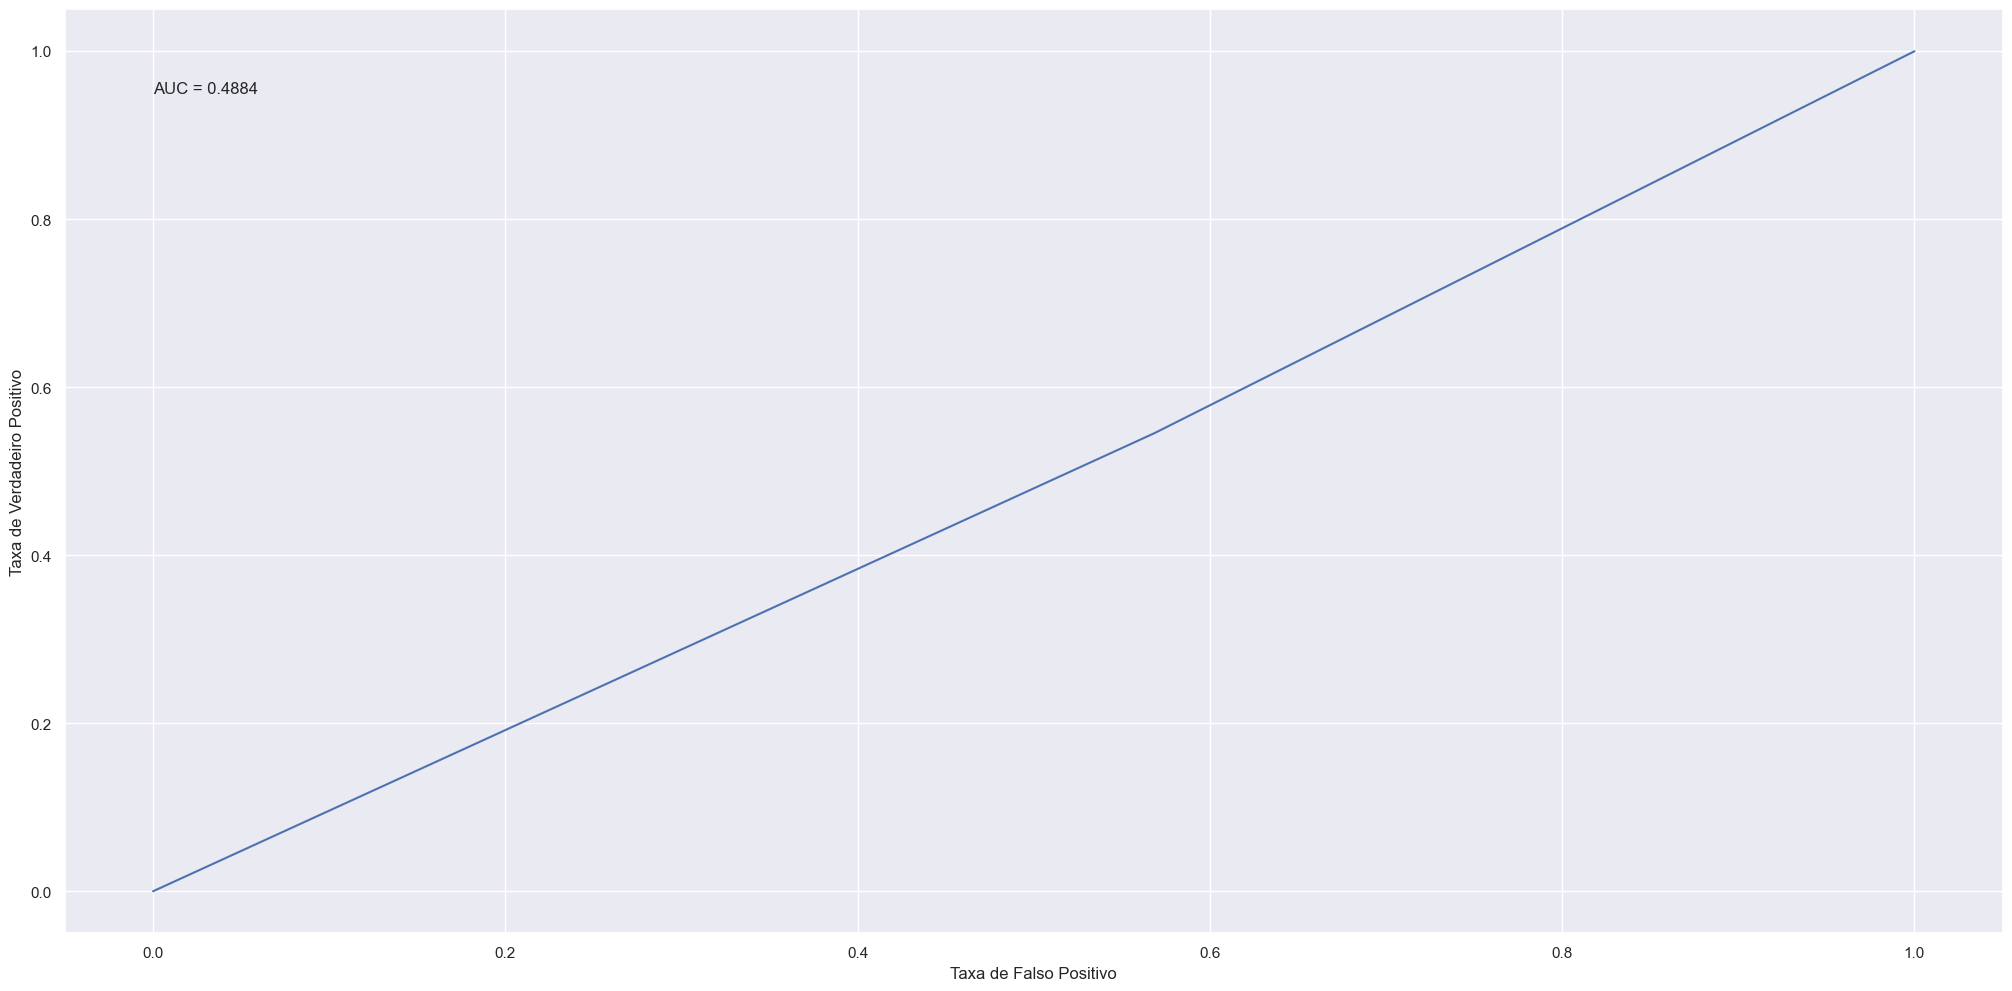

In [364]:
plt.plot(fpr, tpr)
plt.text(0.0, 0.95, "AUC = " + str(round(auc( fpr, tpr ),4)))
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.show();

In [124]:
thresholds

array([2, 1, 0])

In [449]:
clf.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 23, 100)           40800     
                                                                 
 lstm_33 (LSTM)              (None, 23, 100)           80400     
                                                                 
 lstm_34 (LSTM)              (None, 23, 100)           80400     
                                                                 
 lstm_35 (LSTM)              (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [454]:
clf.history